In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set_style('darkgrid')
sns.set_context('poster')

# inline mode and retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [2]:
GRADES_ORDER = ["F", "D-", "D", "D+", "C-", "C", "C+", "B-", "B", "B+", "A-", "A", "A+"]


def load_data(name: str) -> pd.DataFrame:
    data = pd.read_csv(f"../data/processed/{name}.csv")
    data = data.fillna(0)

    # This allows us to plot the grades in natural order
    data["grade_category"] = pd.Categorical(
        data["final_grade"], categories=GRADES_ORDER, ordered=True
    )
    return data

In [3]:
ucsd_data = load_data("ucsd")

In [4]:
feature_cols = [c for c in ucsd_data.columns if "ch" in c]
len(feature_cols)

132

In [5]:
from scipy.stats import zscore

# Get feature matrix and apply z-score normalization on each feature (along columns)
X = ucsd_data[feature_cols].to_numpy()
X = zscore(X, axis=0)

# replace nan with 0.0, this may happen when a feature is not
# e.g., there is not end of chapter summary for chapter 12
X = np.nan_to_num(X, nan=0.0)
X.shape

(183, 132)

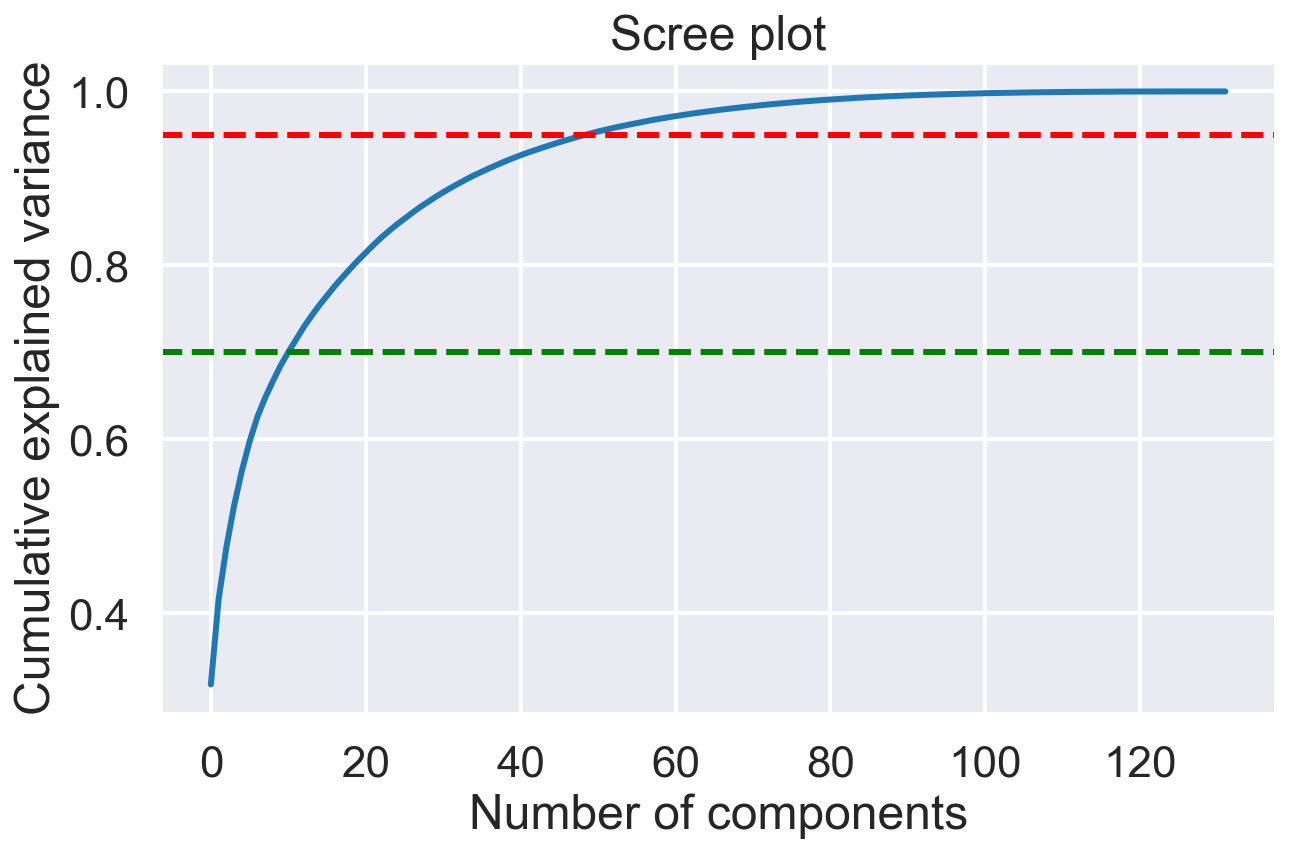

In [6]:
# Apply PCA to reduce the dimensionality of the feature matrix before running clustering algorithms
from sklearn.decomposition import PCA


# We use Scree plot to determine the best number of components
n_features = X.shape[-1]
pca = PCA(n_features).fit(X)  # Starts with the maximum number of components

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.axhline(0.95, color="r", linestyle="--")  # 95% explained variance
plt.axhline(0.7, color="g", linestyle="--")  # 70% explained variance

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Scree plot")
plt.show()

The more number of components we have, the more information we can keep (higher explained variance), we need to make a trade off between the number of components and the explained variance.

Here we keep the number of components at **20**, to achieve above **0.8** explained variance.

In [7]:
pca = PCA(n_components=20)  # We choose 20 components
X_pca = pca.fit_transform(X)
X_pca.shape

(183, 20)

# Clustering

In [8]:
from sklearn.cluster import KMeans

N_CLUSTER = 2

kmeans = KMeans(n_clusters=N_CLUSTER, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=2, random_state=42)

In [9]:
ucsd_data["cluster"] = kmeans.labels_

In [12]:
# Plot the grade histogram by cluster
ucsd_sorted = ucsd_data.sort_values(by="grade_category")

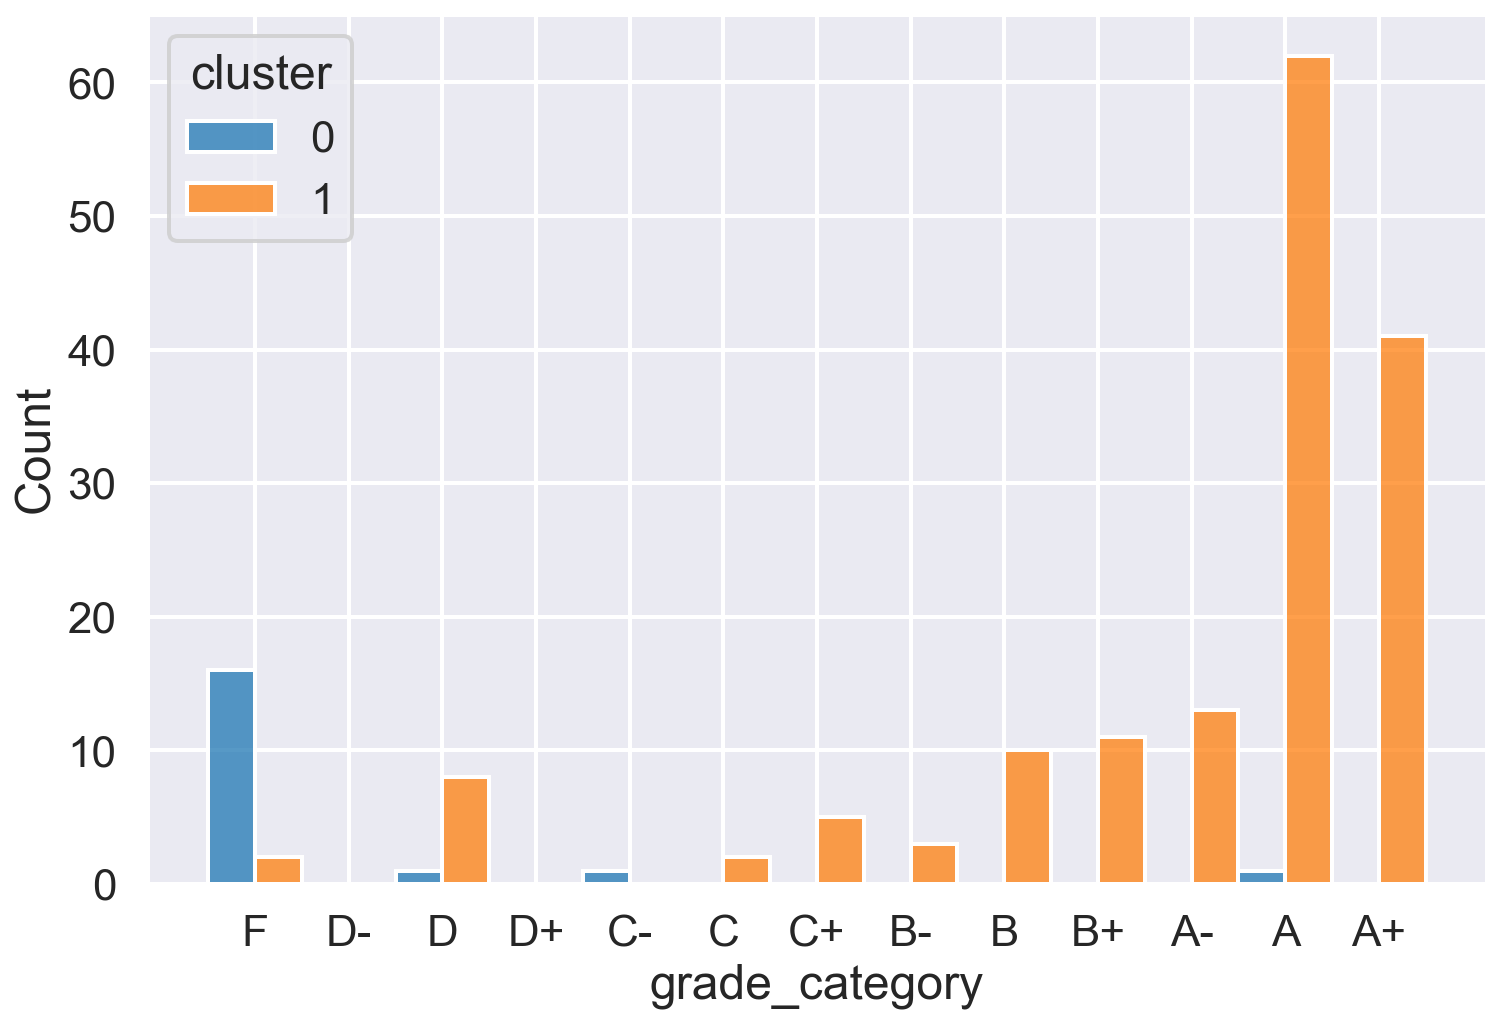

In [13]:
# plot histogram of final grade faceted by cluster
plt.figure(figsize=(12, 8))
g = sns.histplot(data=ucsd_sorted, x="grade_category", hue="cluster", multiple="dodge")

In [14]:
FEATURE_NAME_BY_FEATURE = {
    "n_sessions": "n",
    "mean_durations": "d_mean",
    "max_durations": "d_max",
    "total_durations": "d_total",
    "review_questions": "q",
    "engagement_ratio": "er",
    "inline_questions_first_attempt": "pr_first",
    "inline_questions_last_attempt": "pr_last",
    "inline_questions_avg_attempts": "attempts_mean",
    "summary_len": "summary_len",
    "mean_pages_per_session": "sp_mean",
}


def _valid_chapters_for_feature(feature: str) -> list[int]:
    """Return the chapter numbers that are valid for the given feature."""
    if feature == "review_questions":
        return list(range(1, 10))
    if feature == "summary_len":
        return [1, 2, 3, 5, 6, 8, 9, 10, 11]
    return list(range(1, 13))


def plot_feature_by_cluster(df: pd.DataFrame, feature: str, hue="cluster"):
    feature_name = FEATURE_NAME_BY_FEATURE[feature]
    chapters = _valid_chapters_for_feature(feature)

    feature_dfs: list[pd.DataFrame] = []
    for n in chapters:
        feature_df = df[[f"ch{n:02d}_{feature_name}", hue]]
        feature_df = feature_df.rename(columns={f"ch{n:02d}_{feature_name}": feature})
        feature_df["chapter"] = n
        feature_dfs.append(feature_df)

    data = pd.concat(feature_dfs, ignore_index=True)

    plt.figure(figsize=(15, 8))
    g = sns.lineplot(data=data, x="chapter", y=feature, hue=hue, marker="o")
    g.set_title(f"{feature} by chapter and {hue}", pad=20)

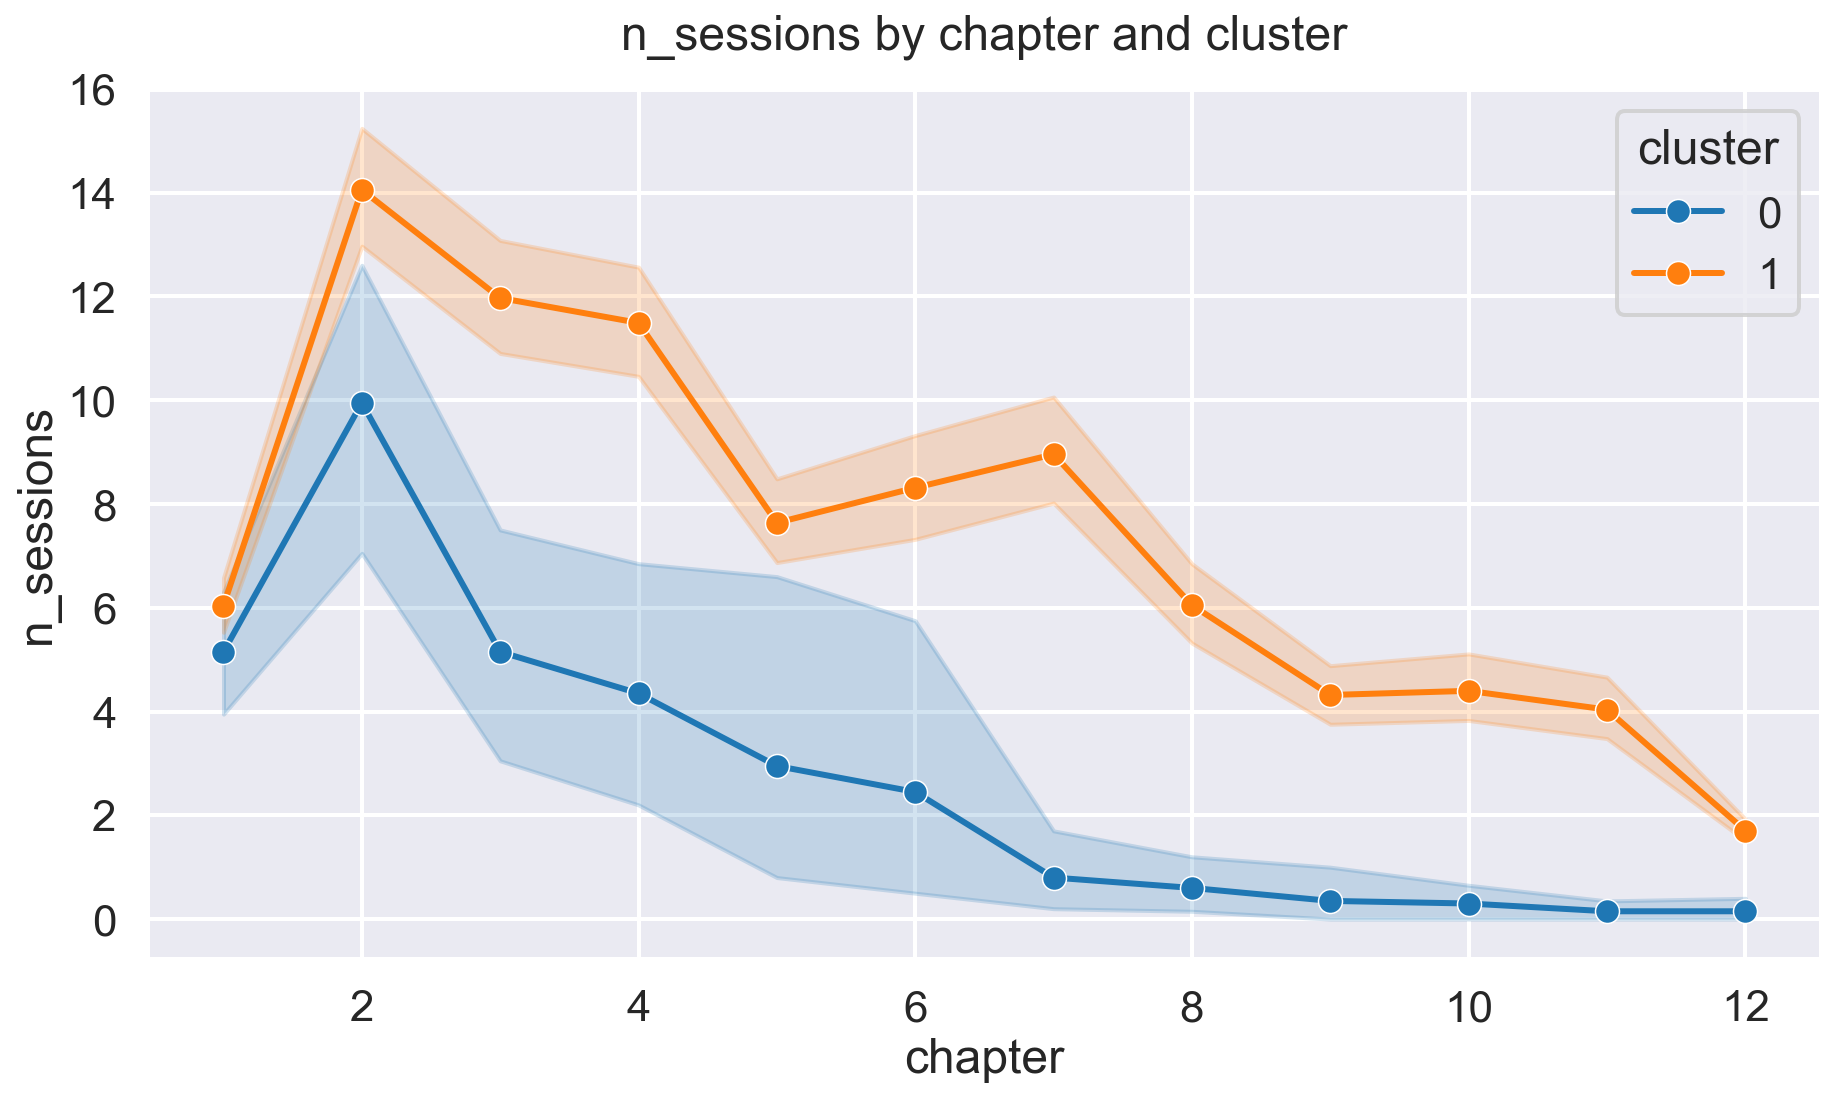

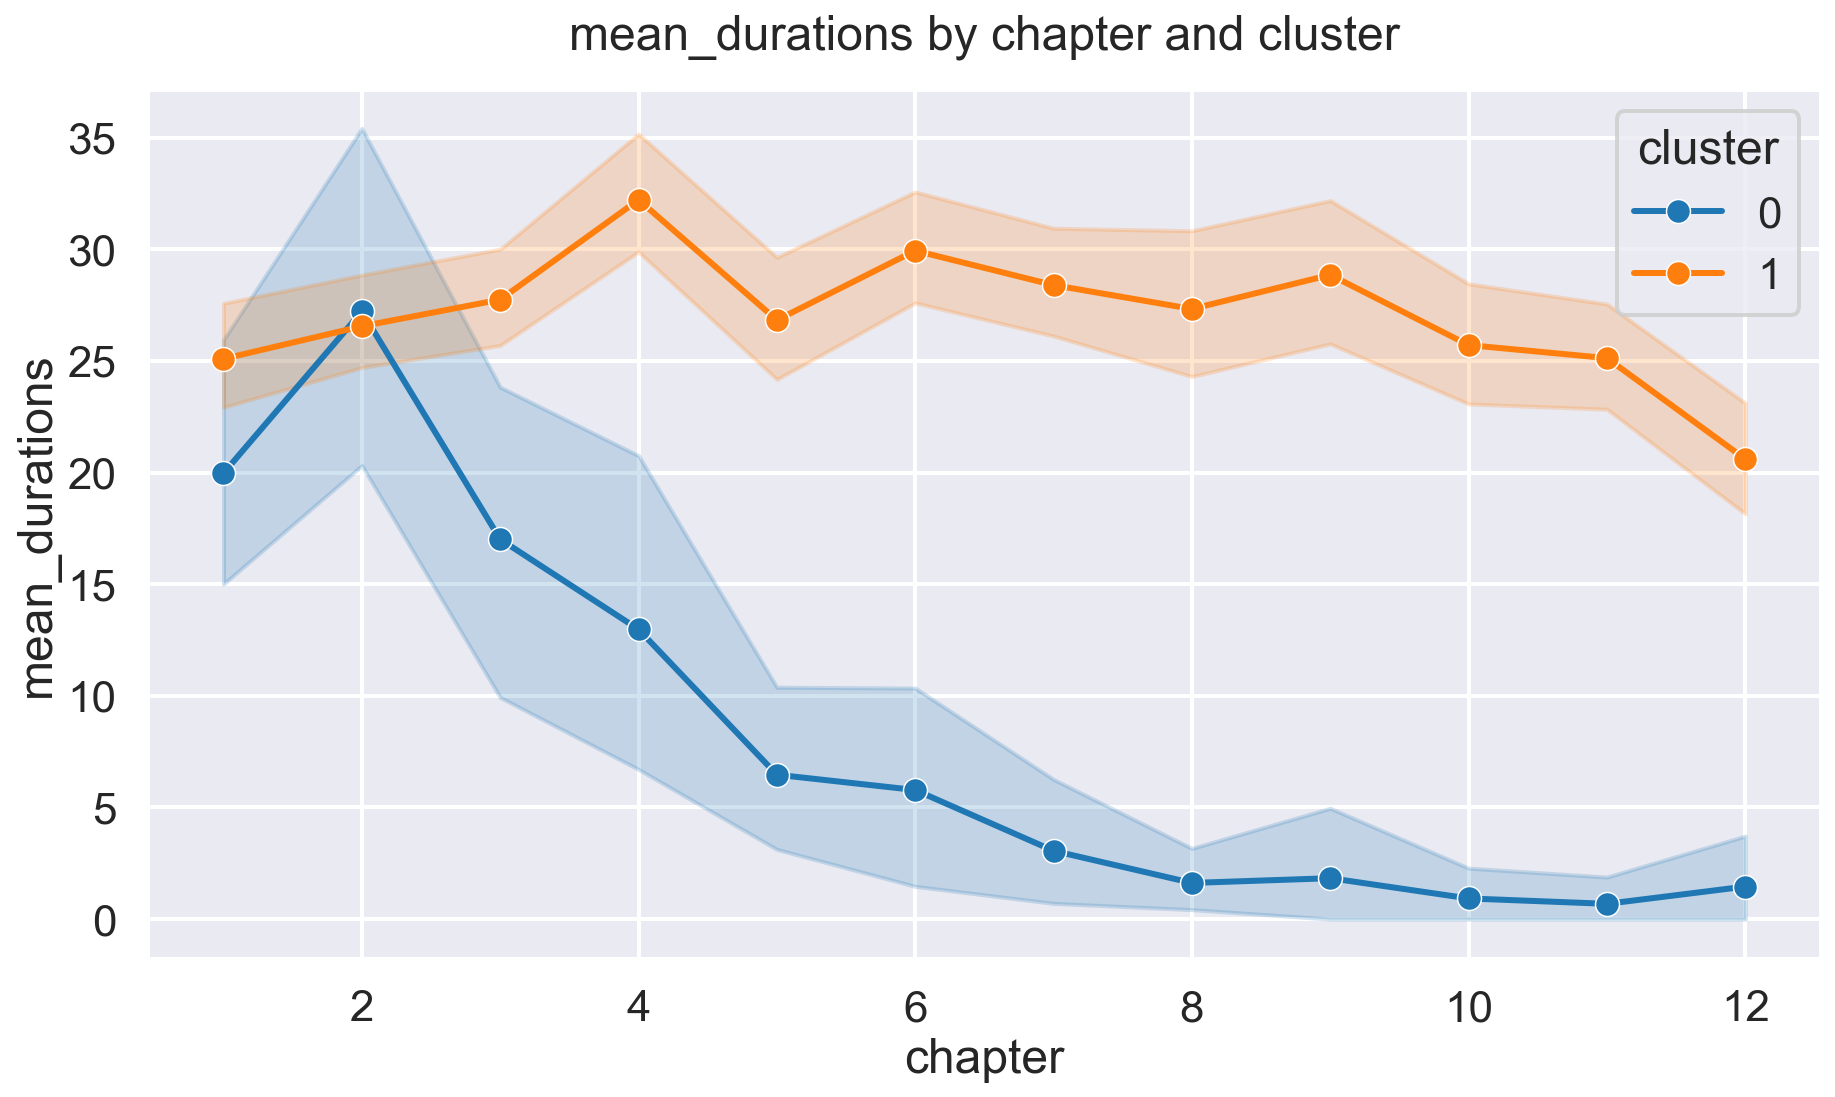

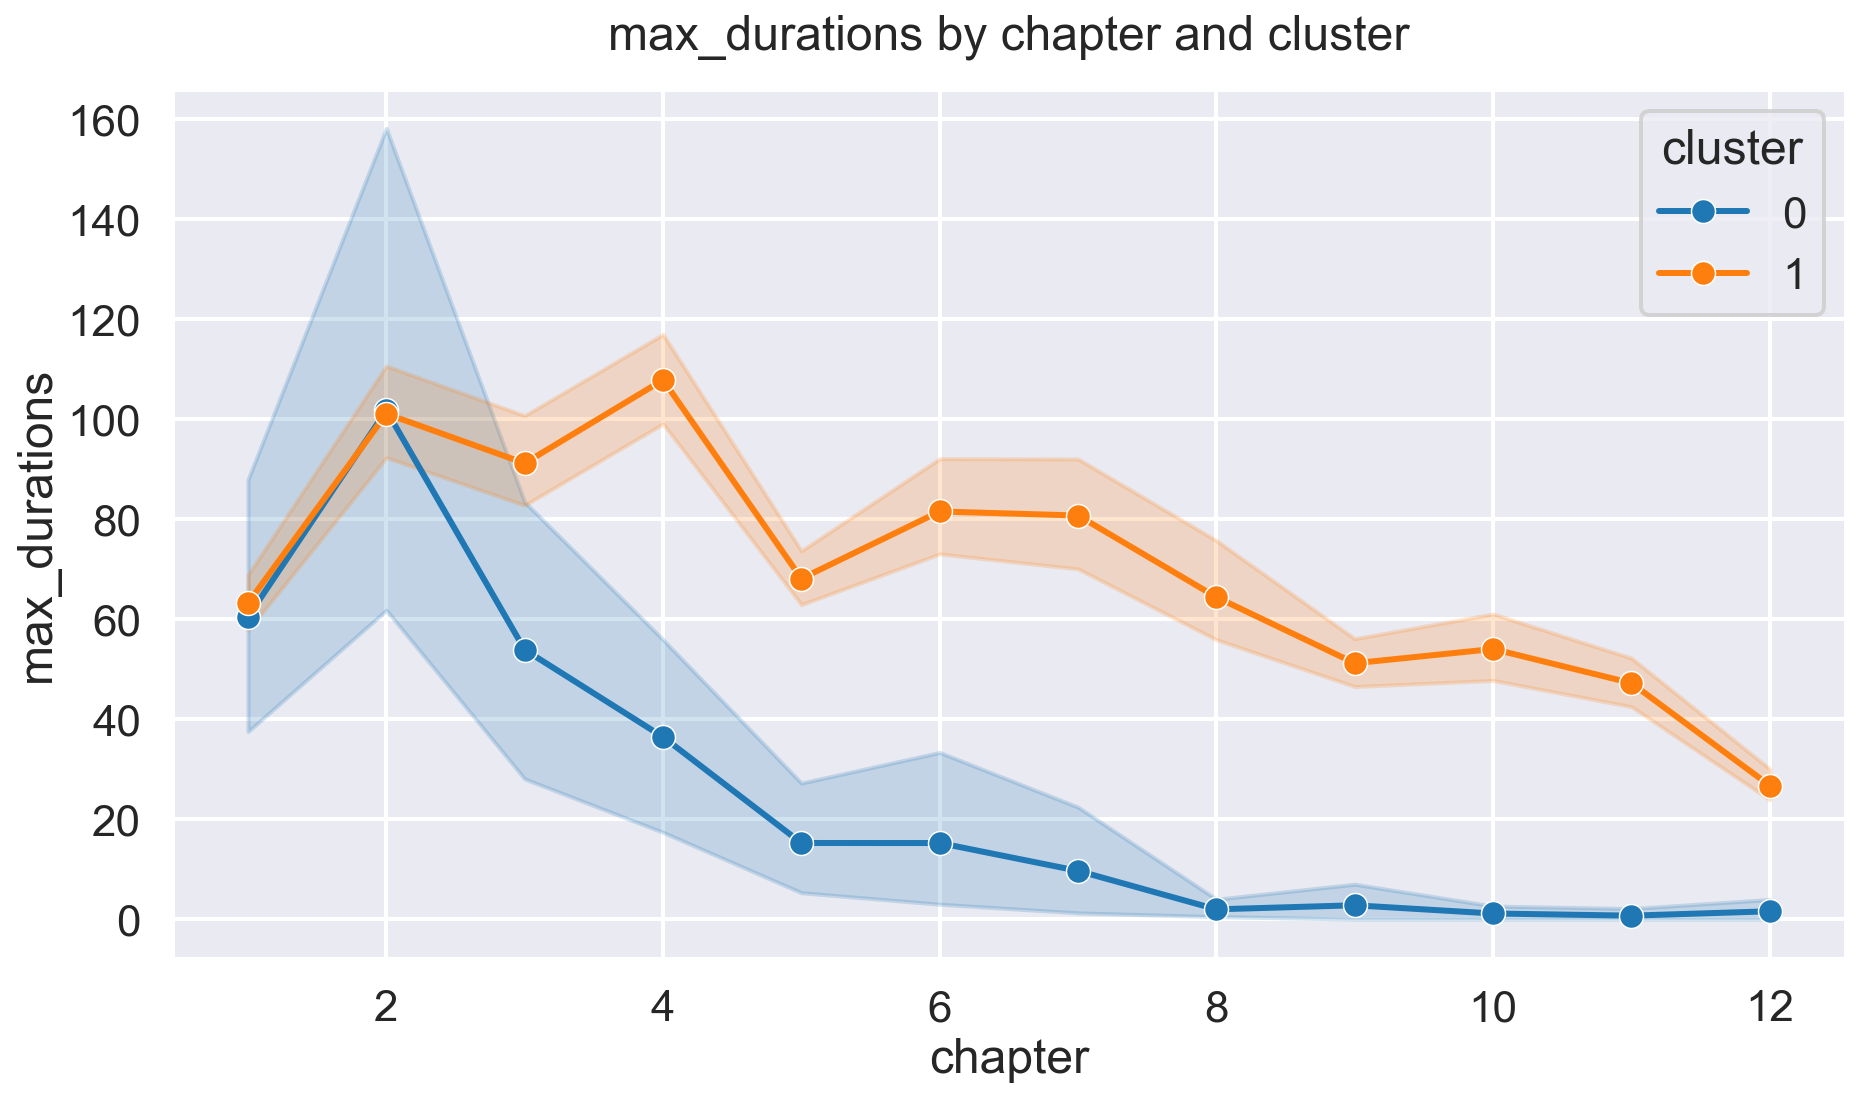

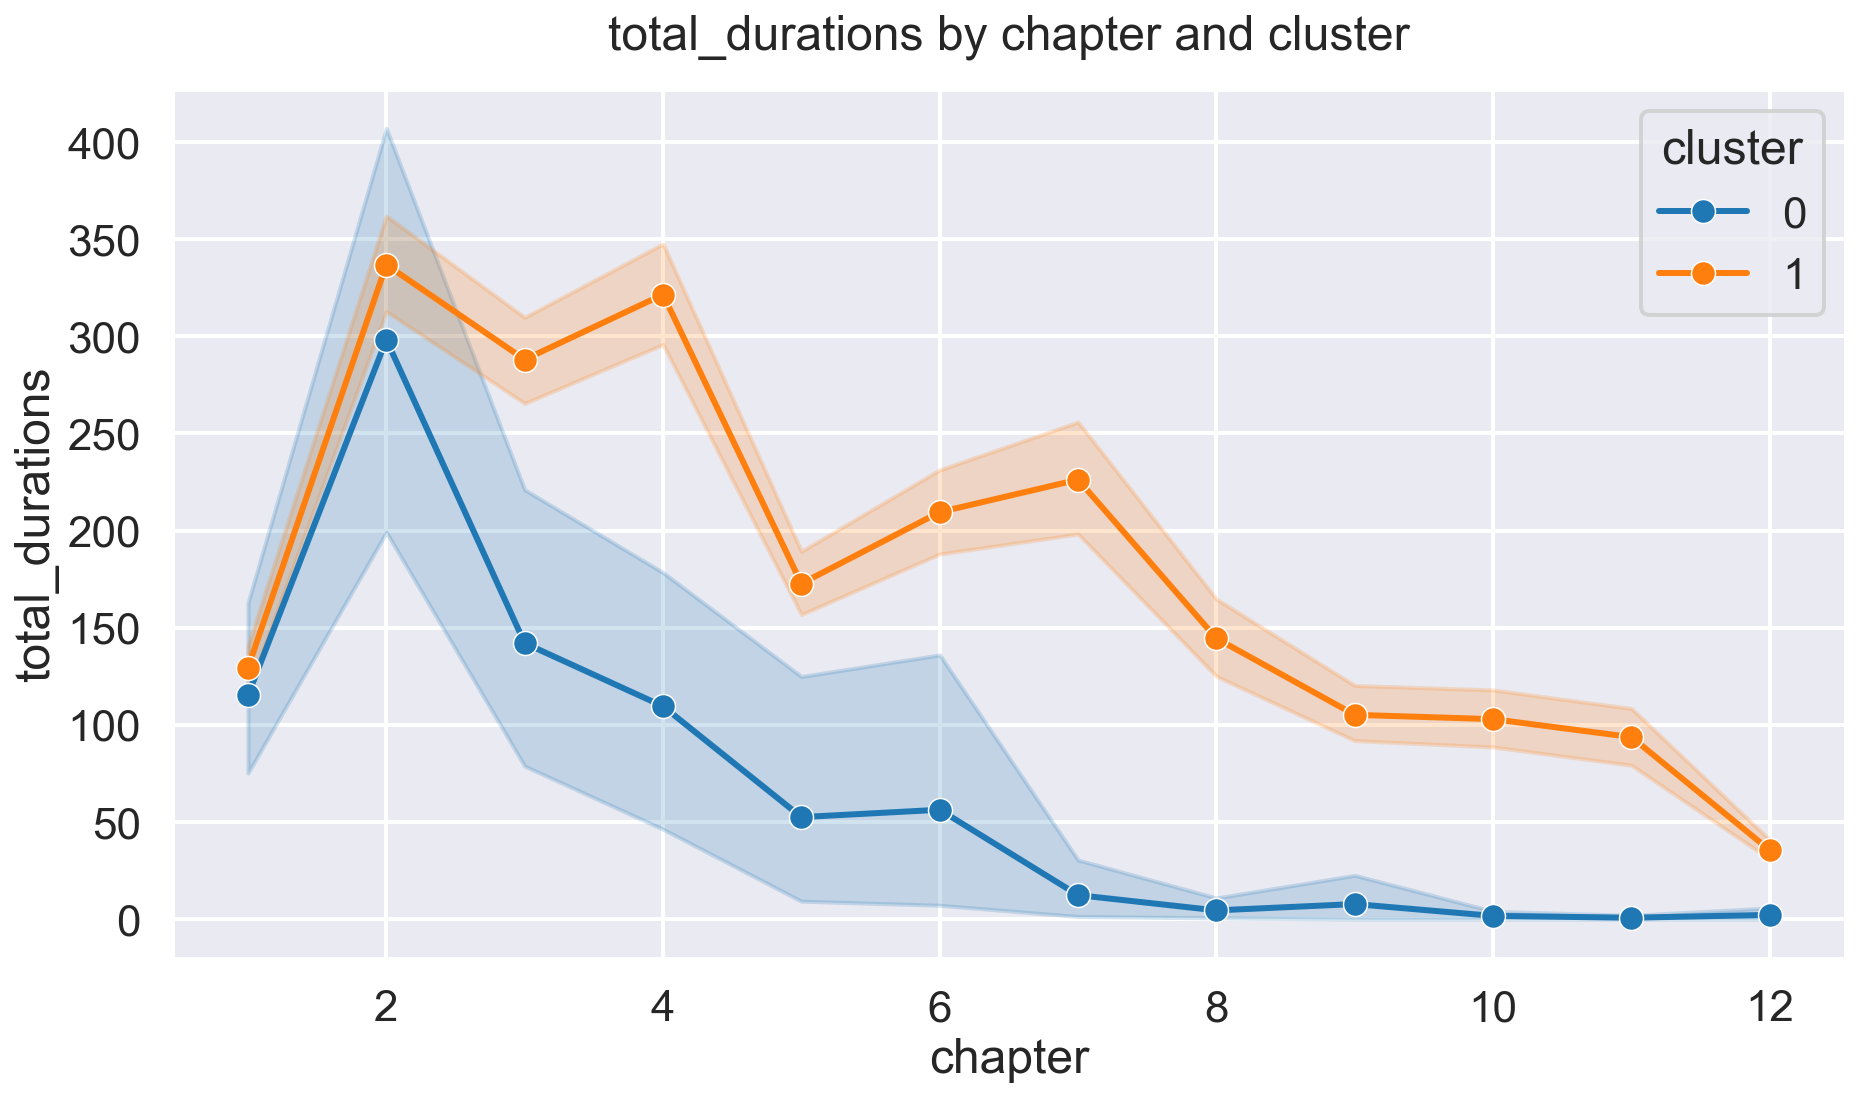

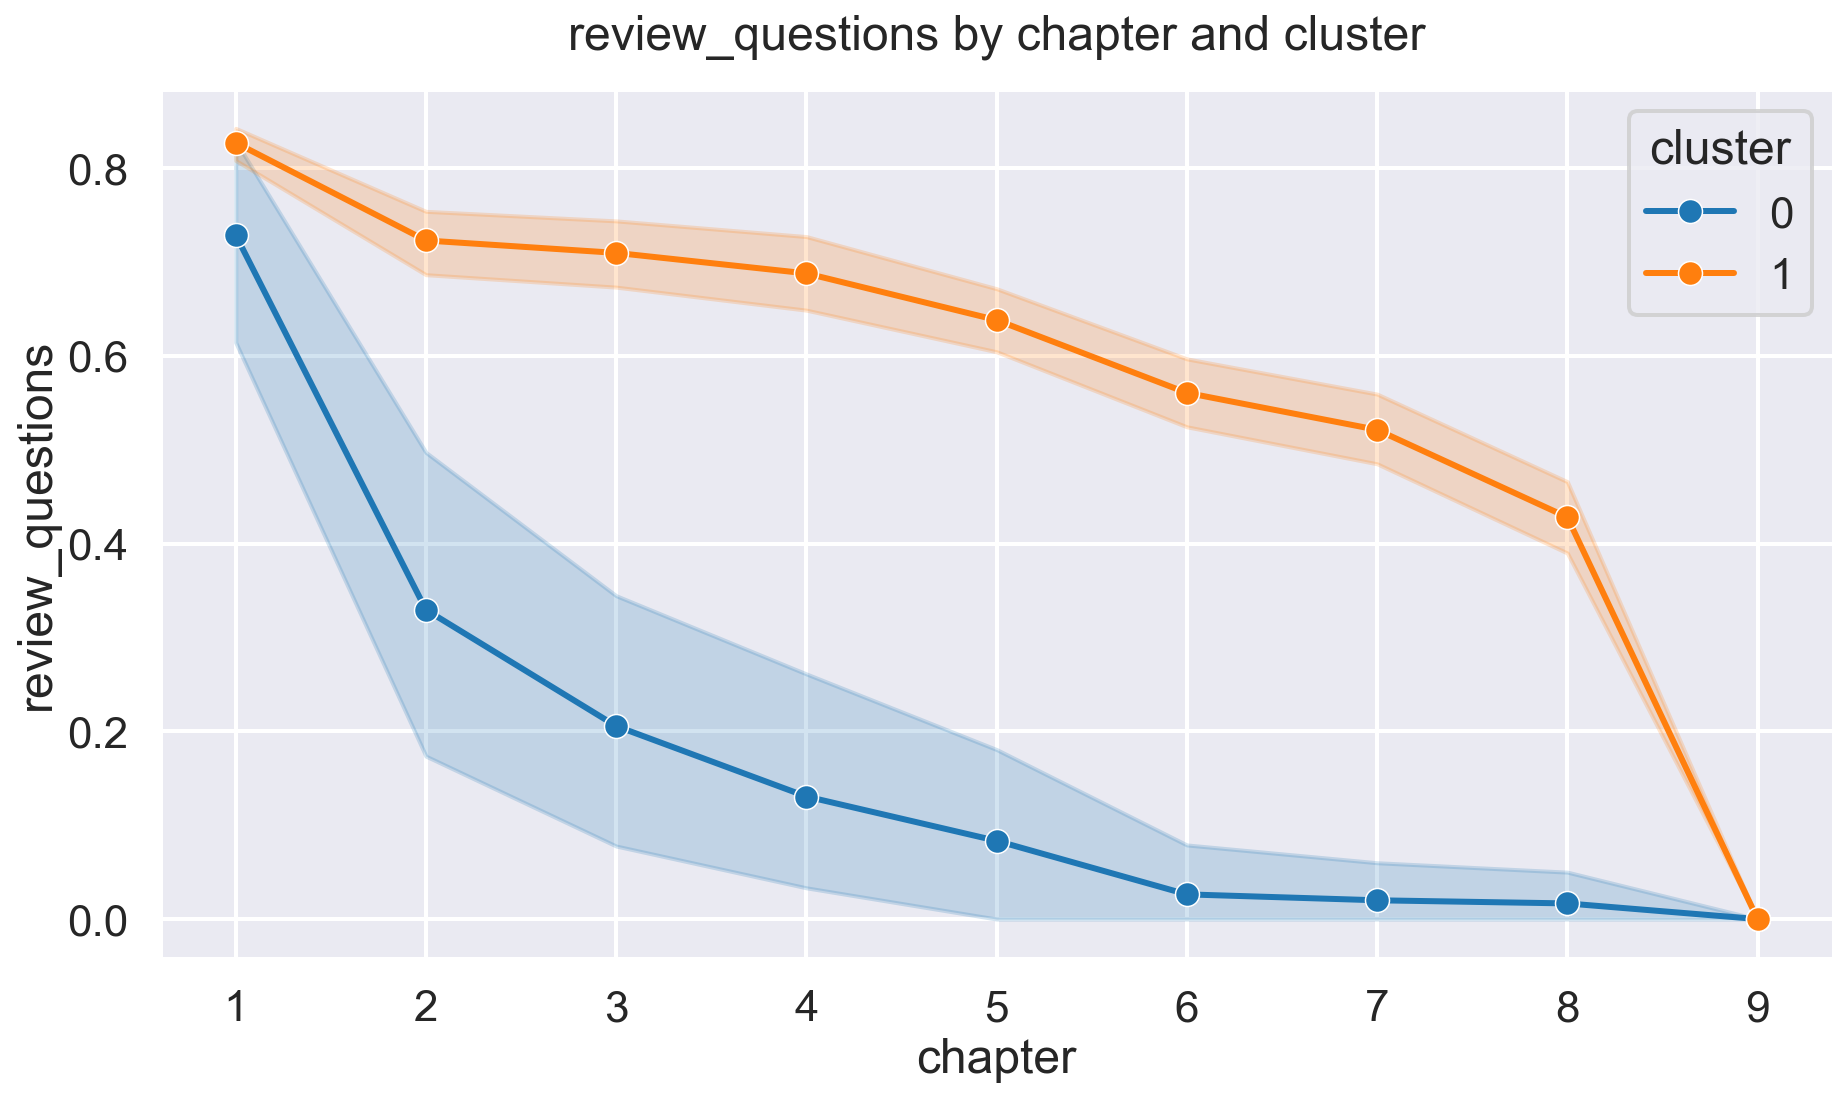

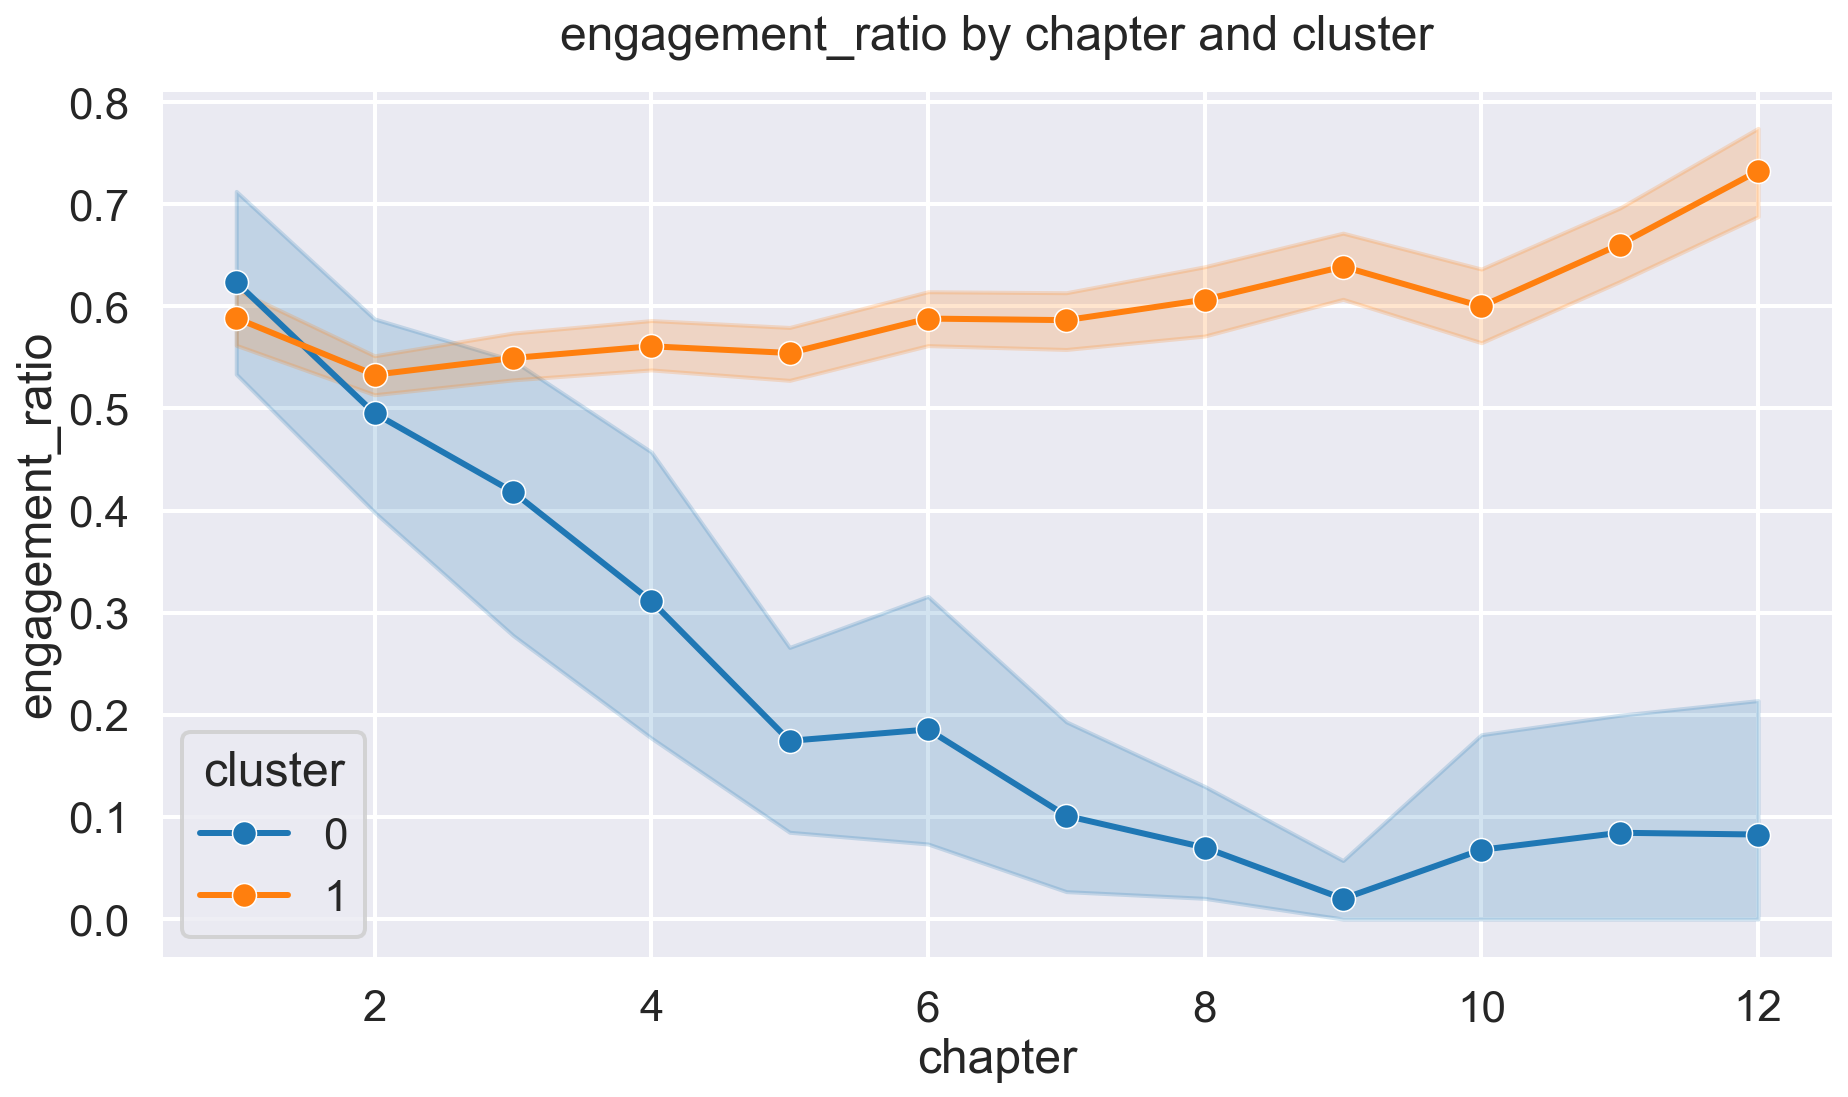

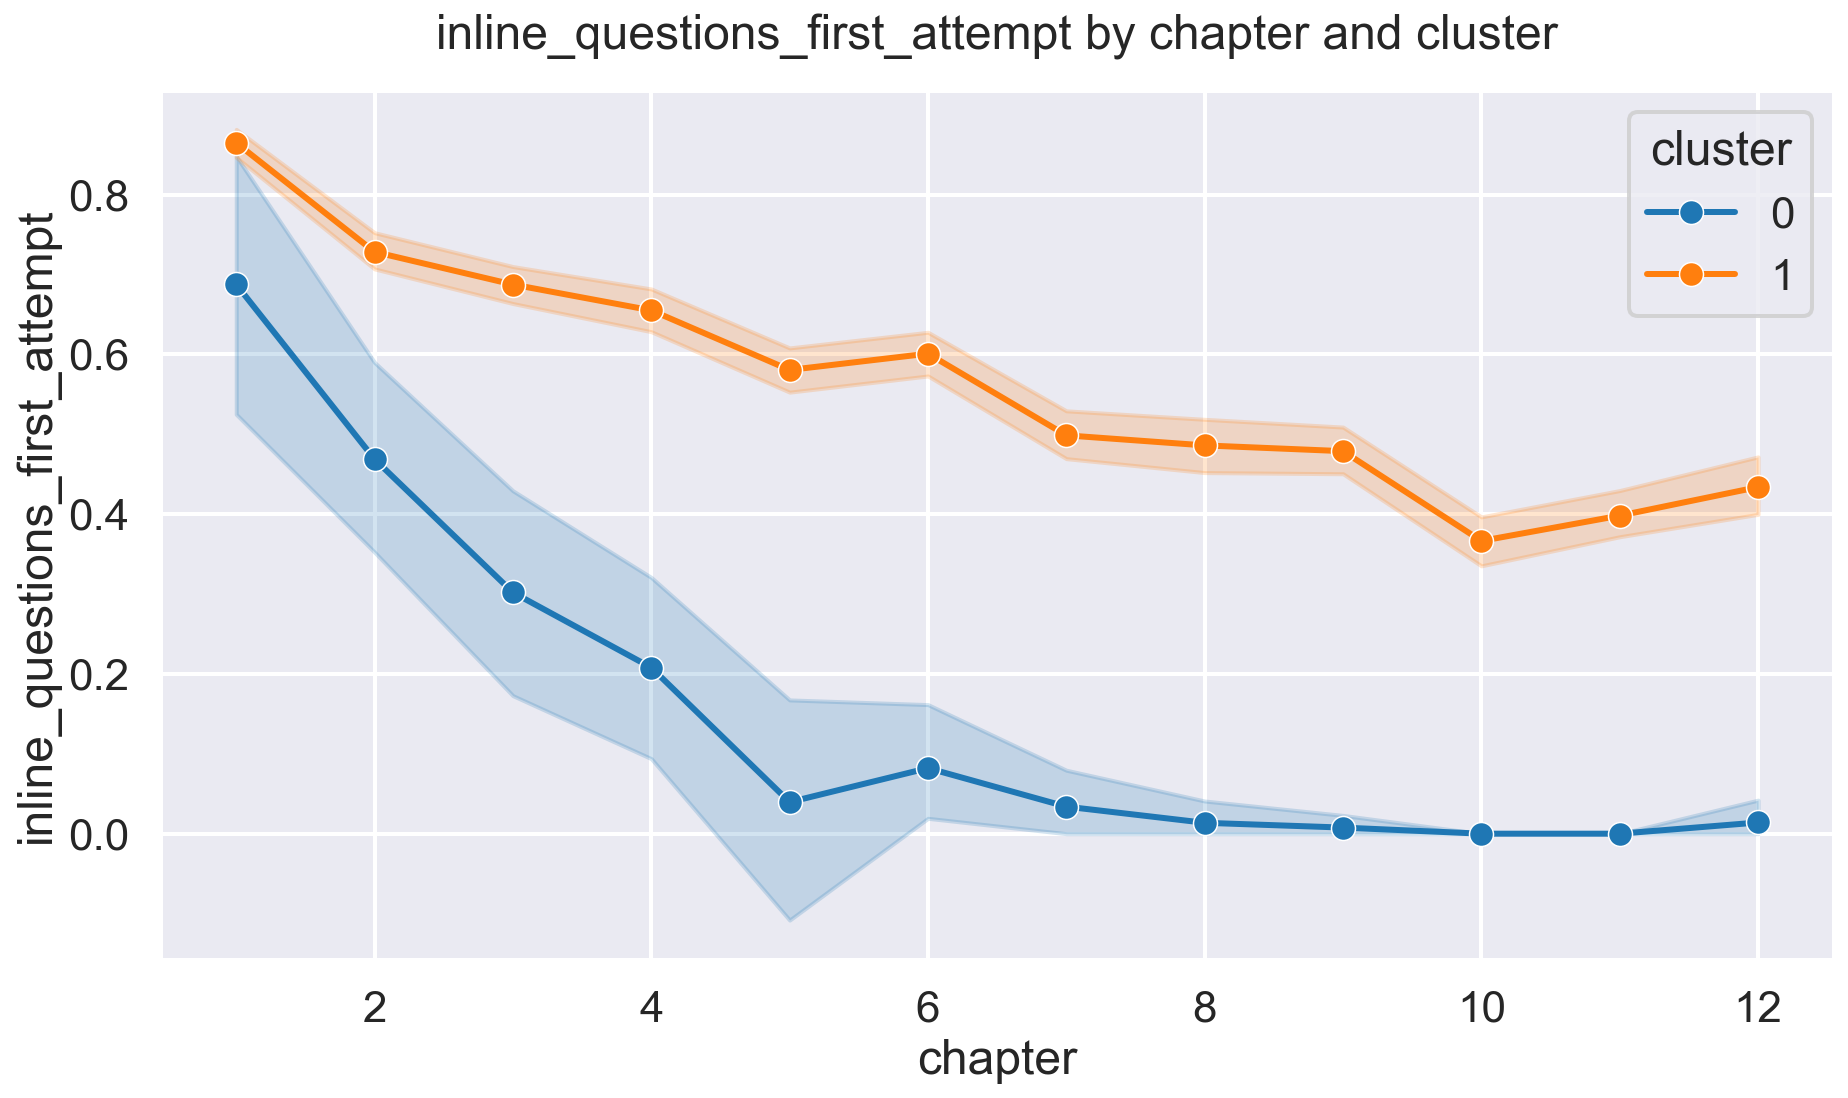

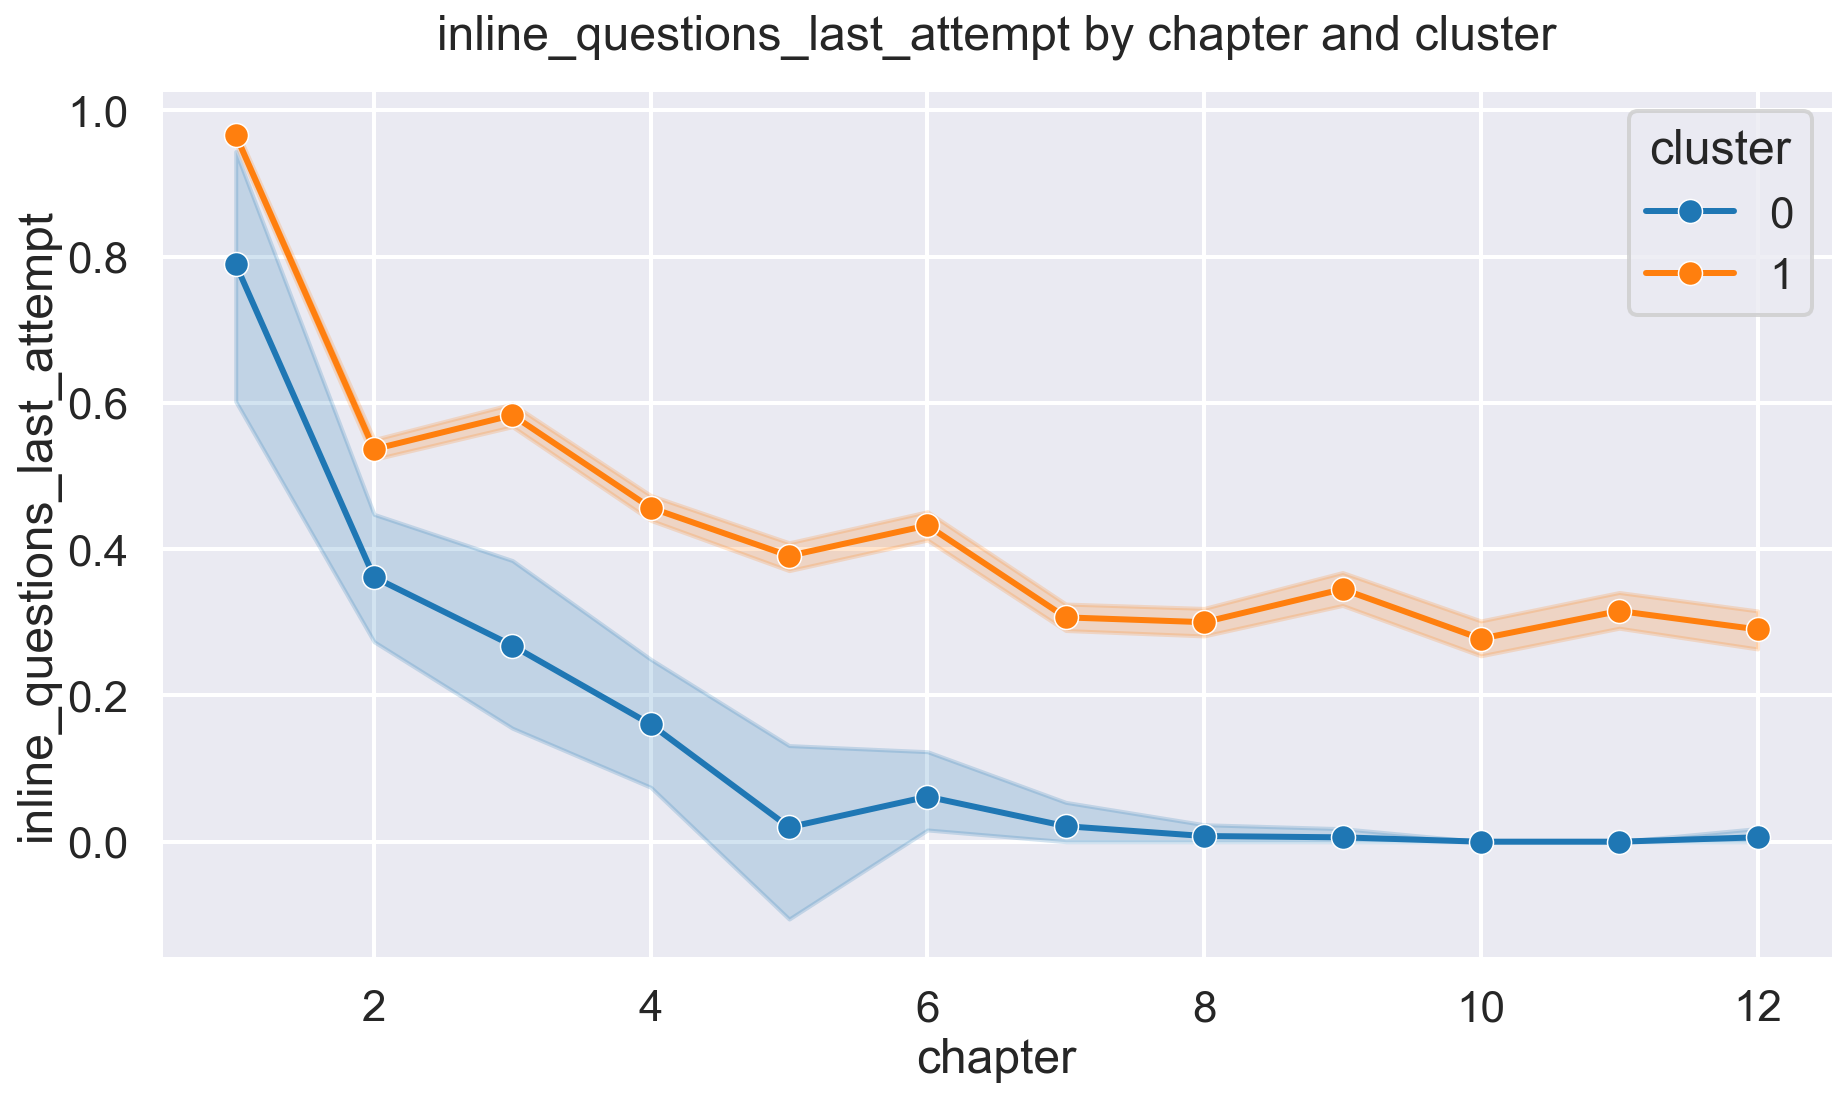

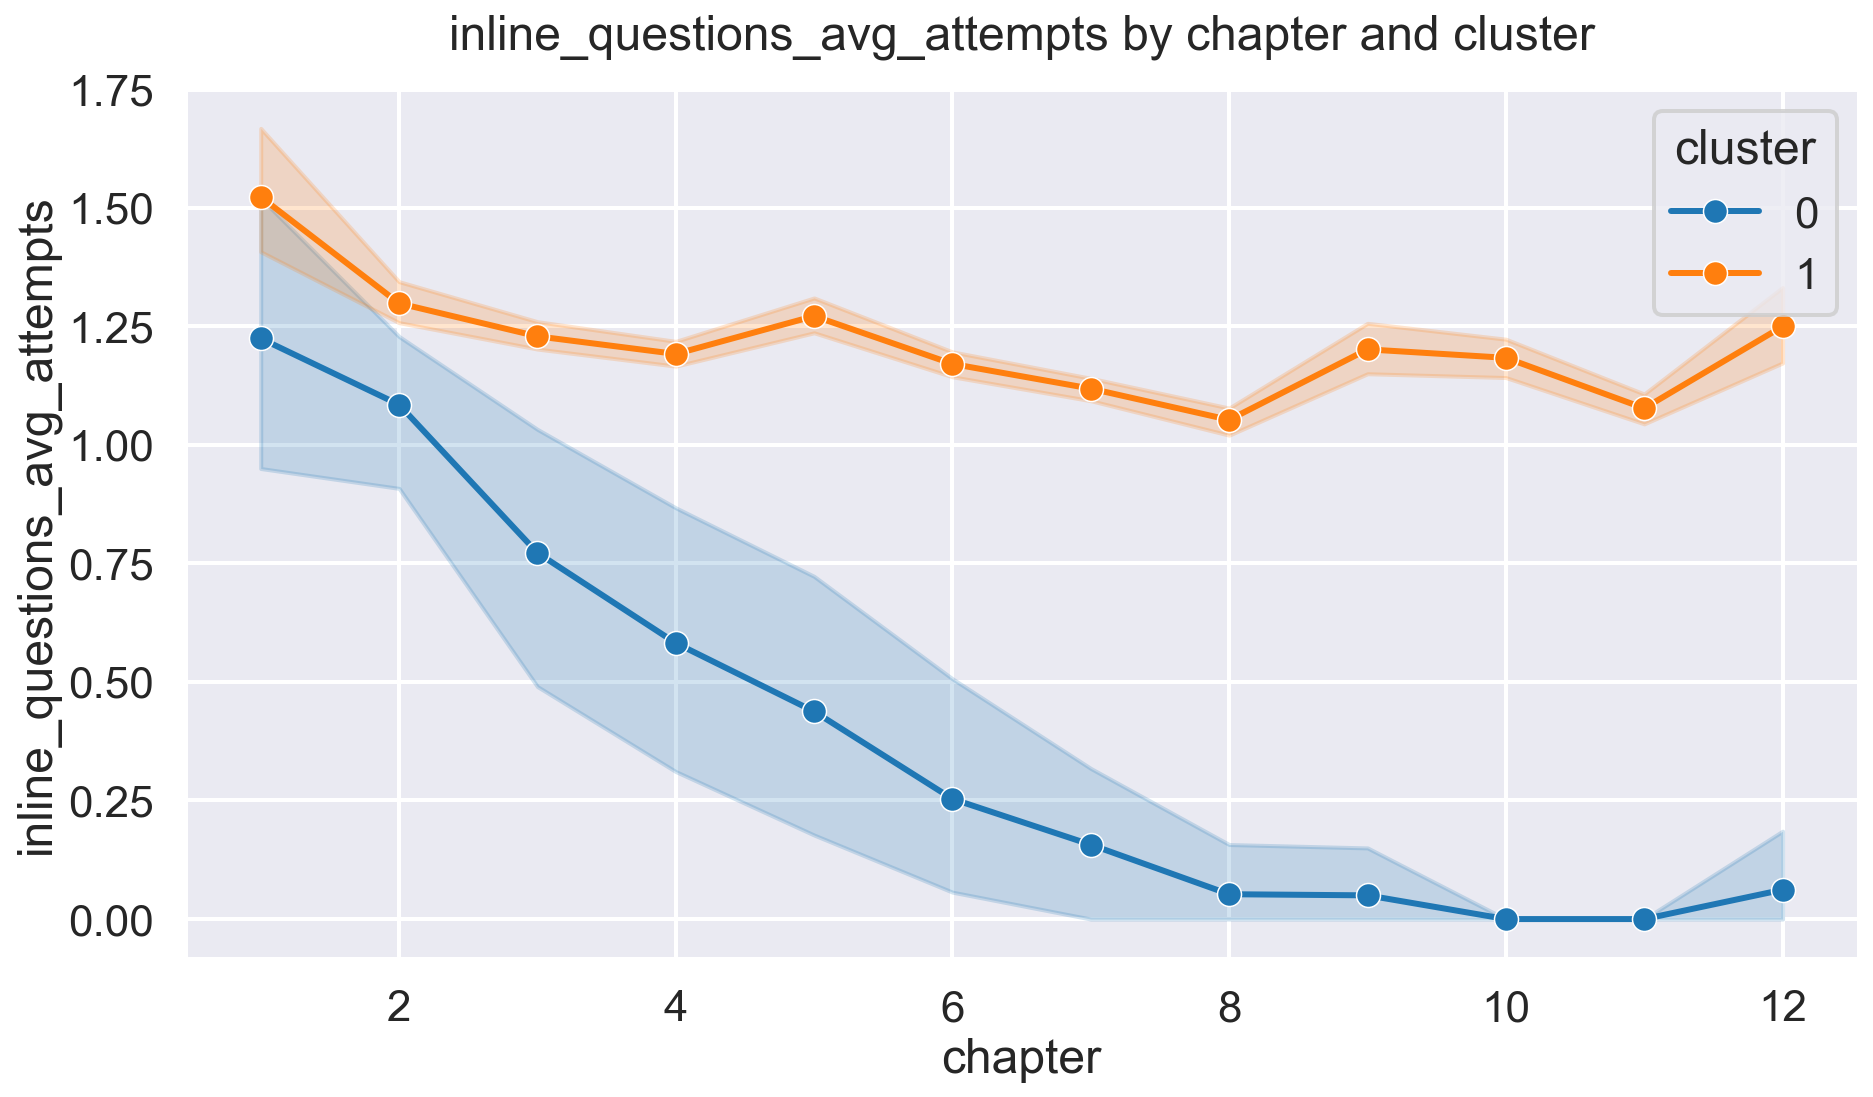

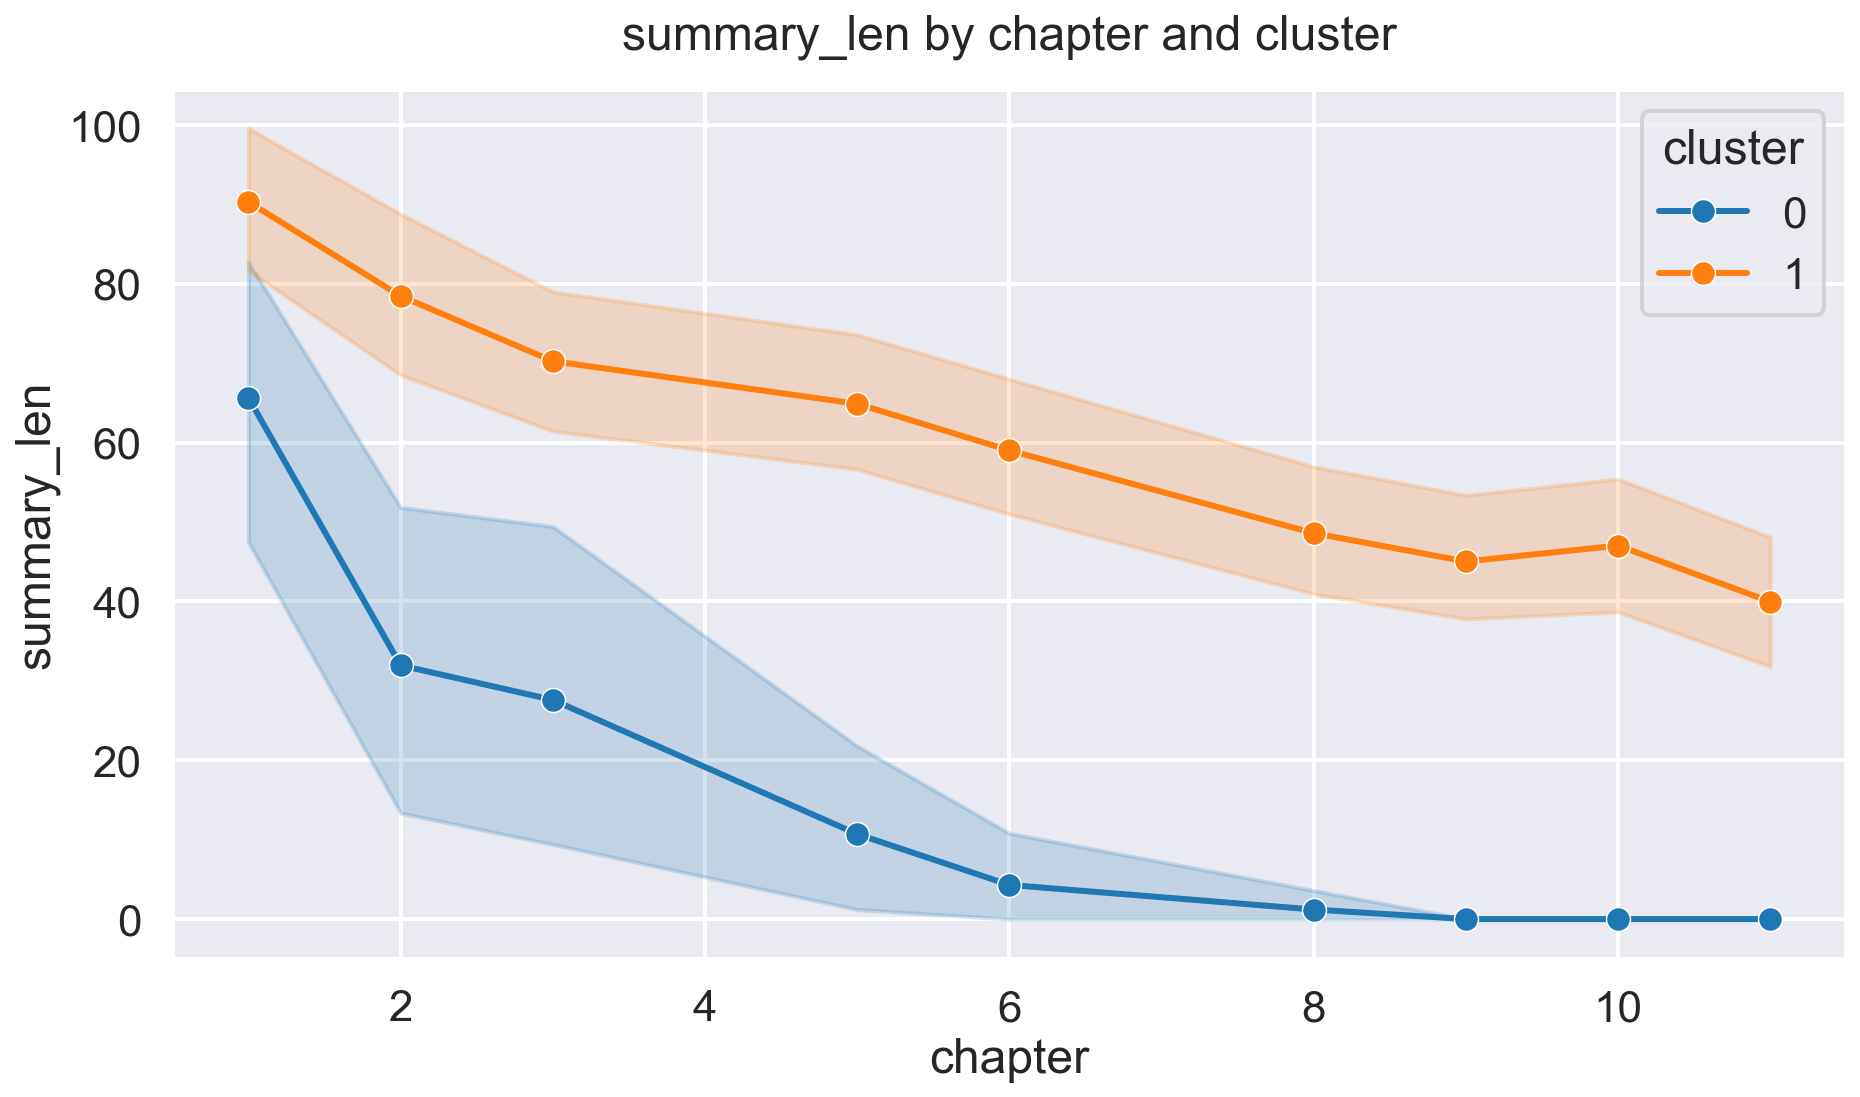

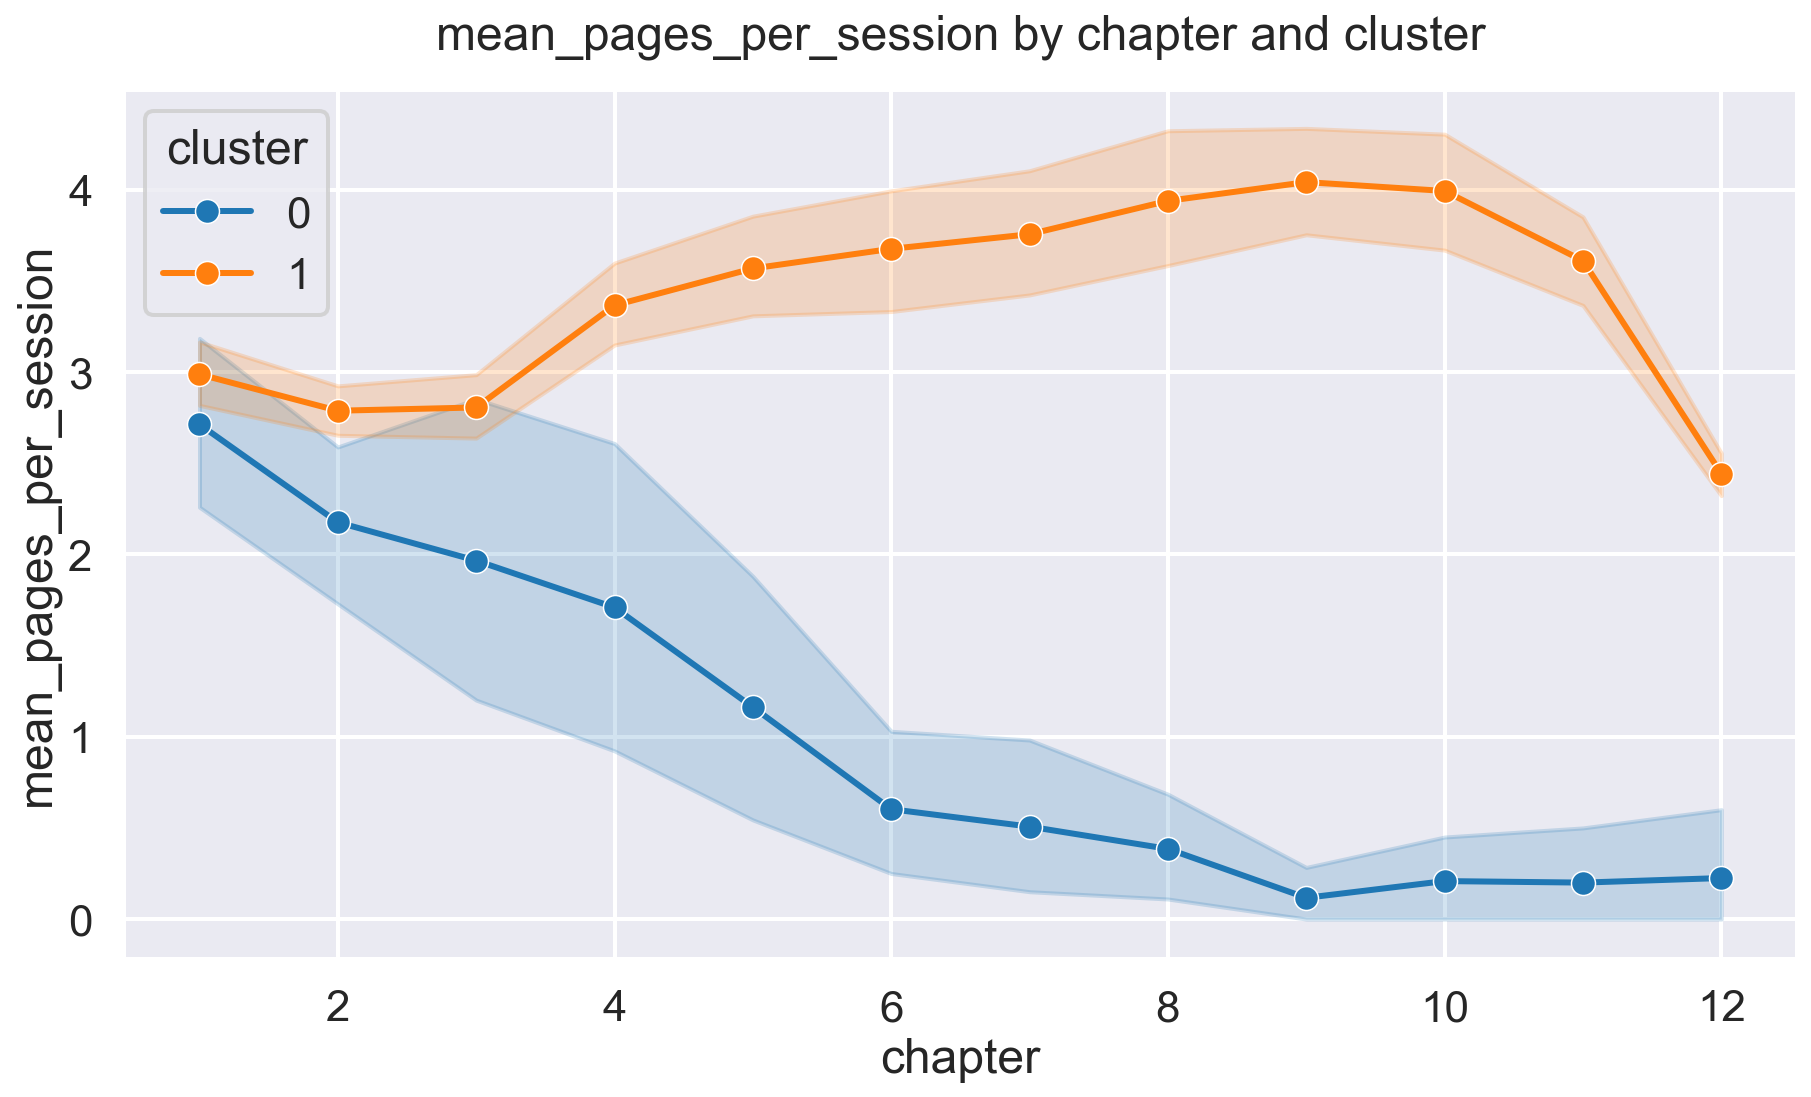

In [15]:
for feature in FEATURE_NAME_BY_FEATURE.keys():
    plot_feature_by_cluster(ucsd_data, feature)

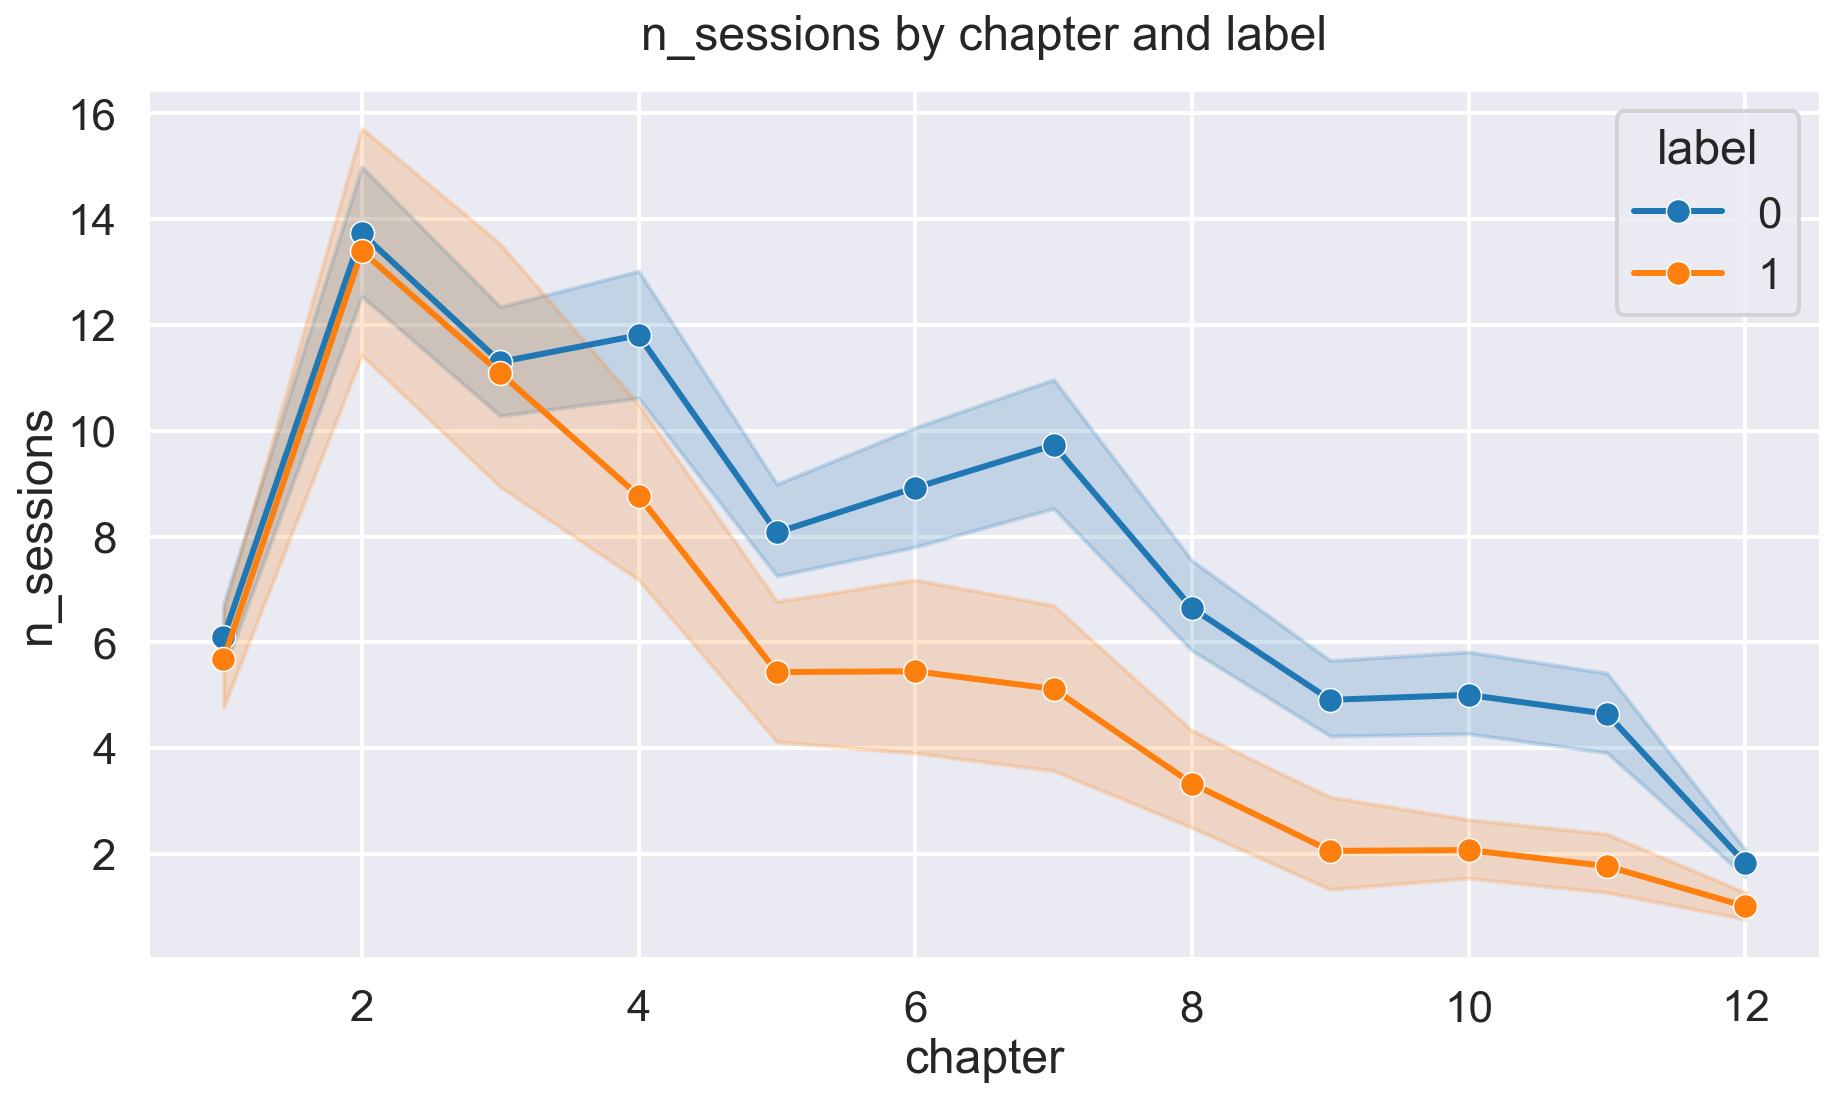

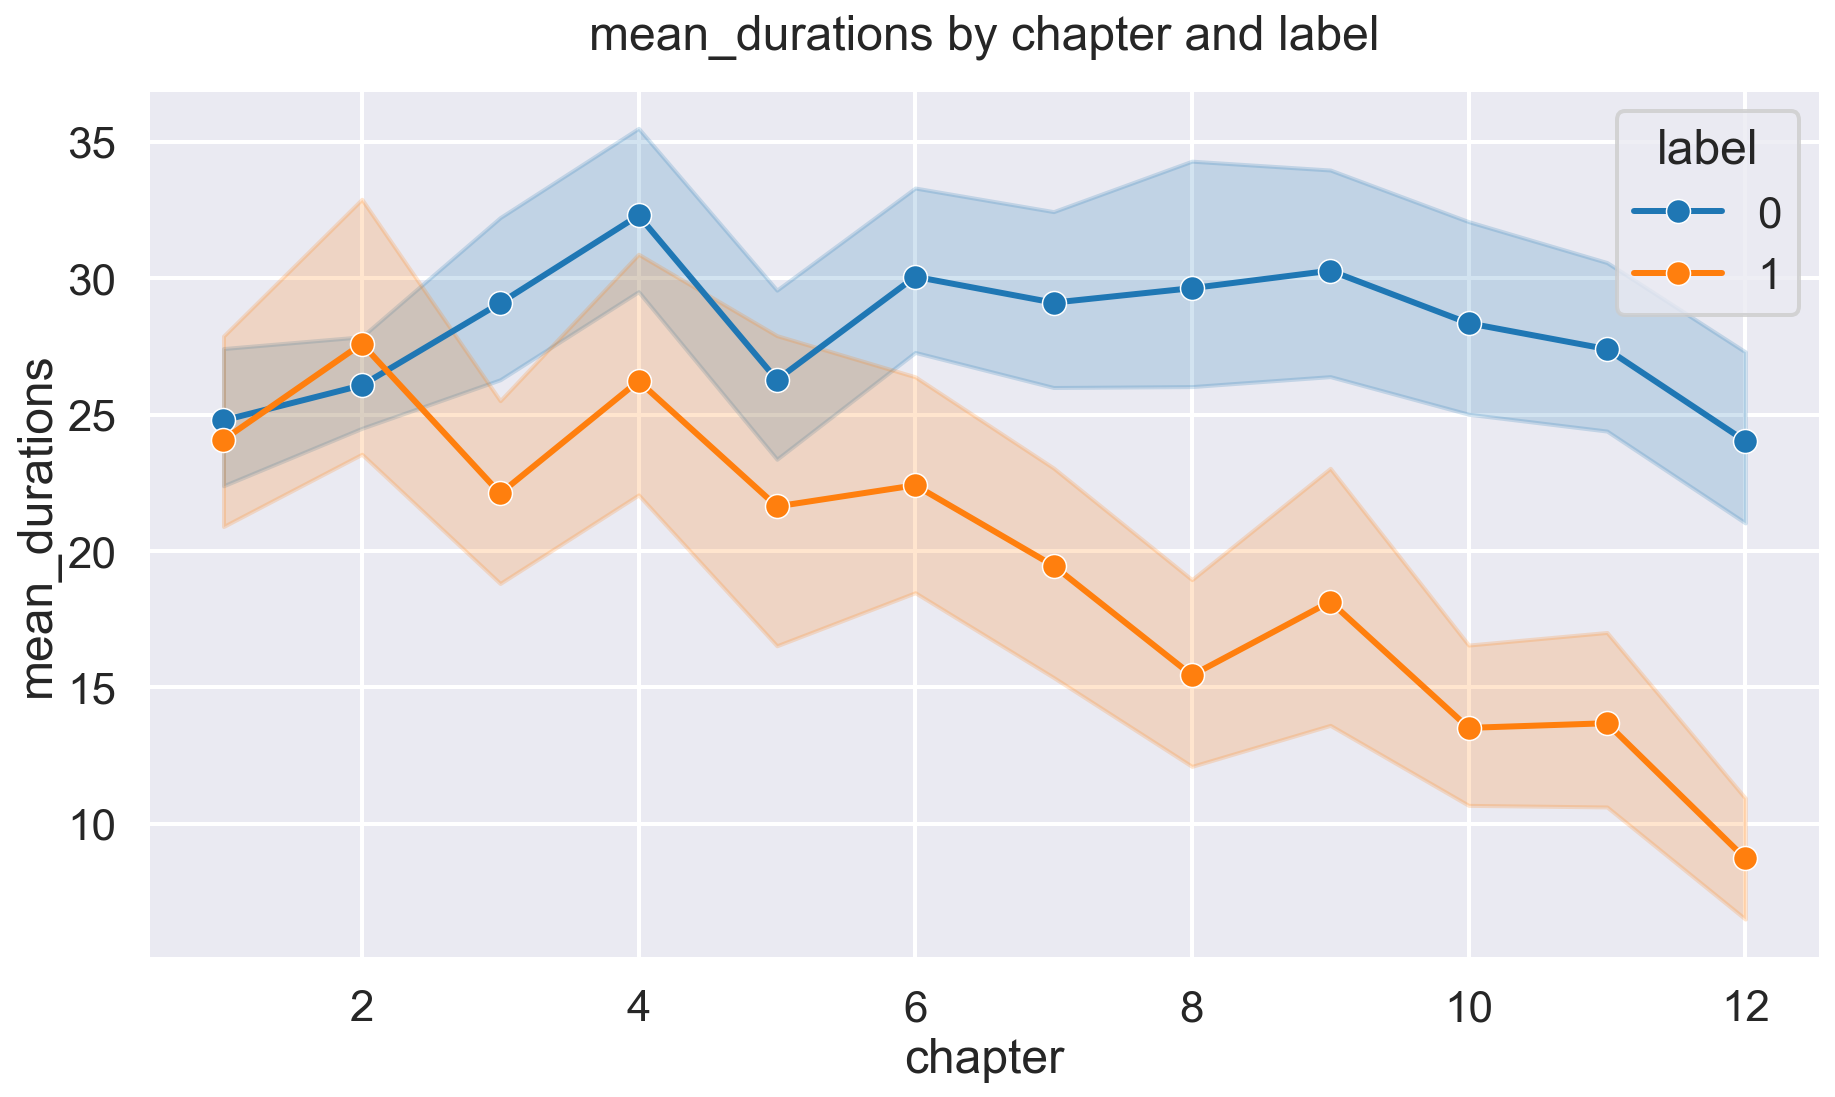

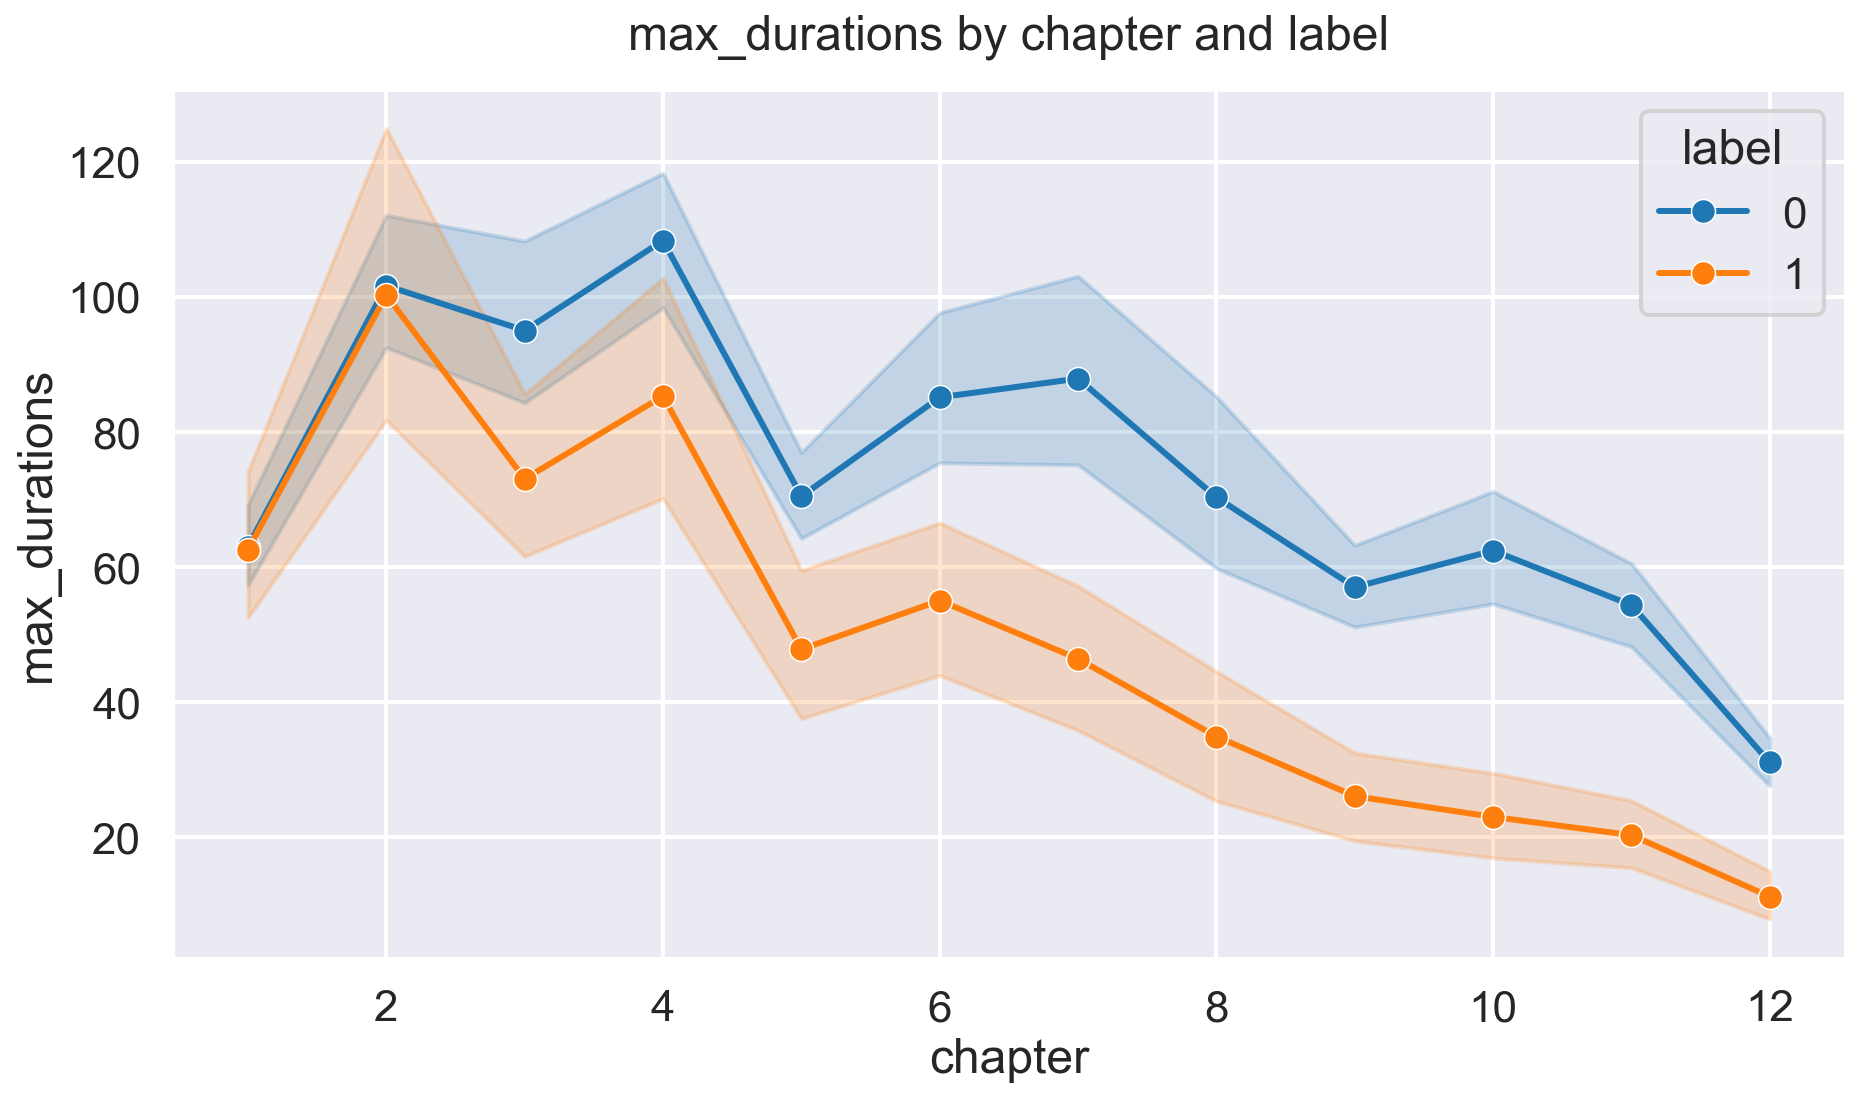

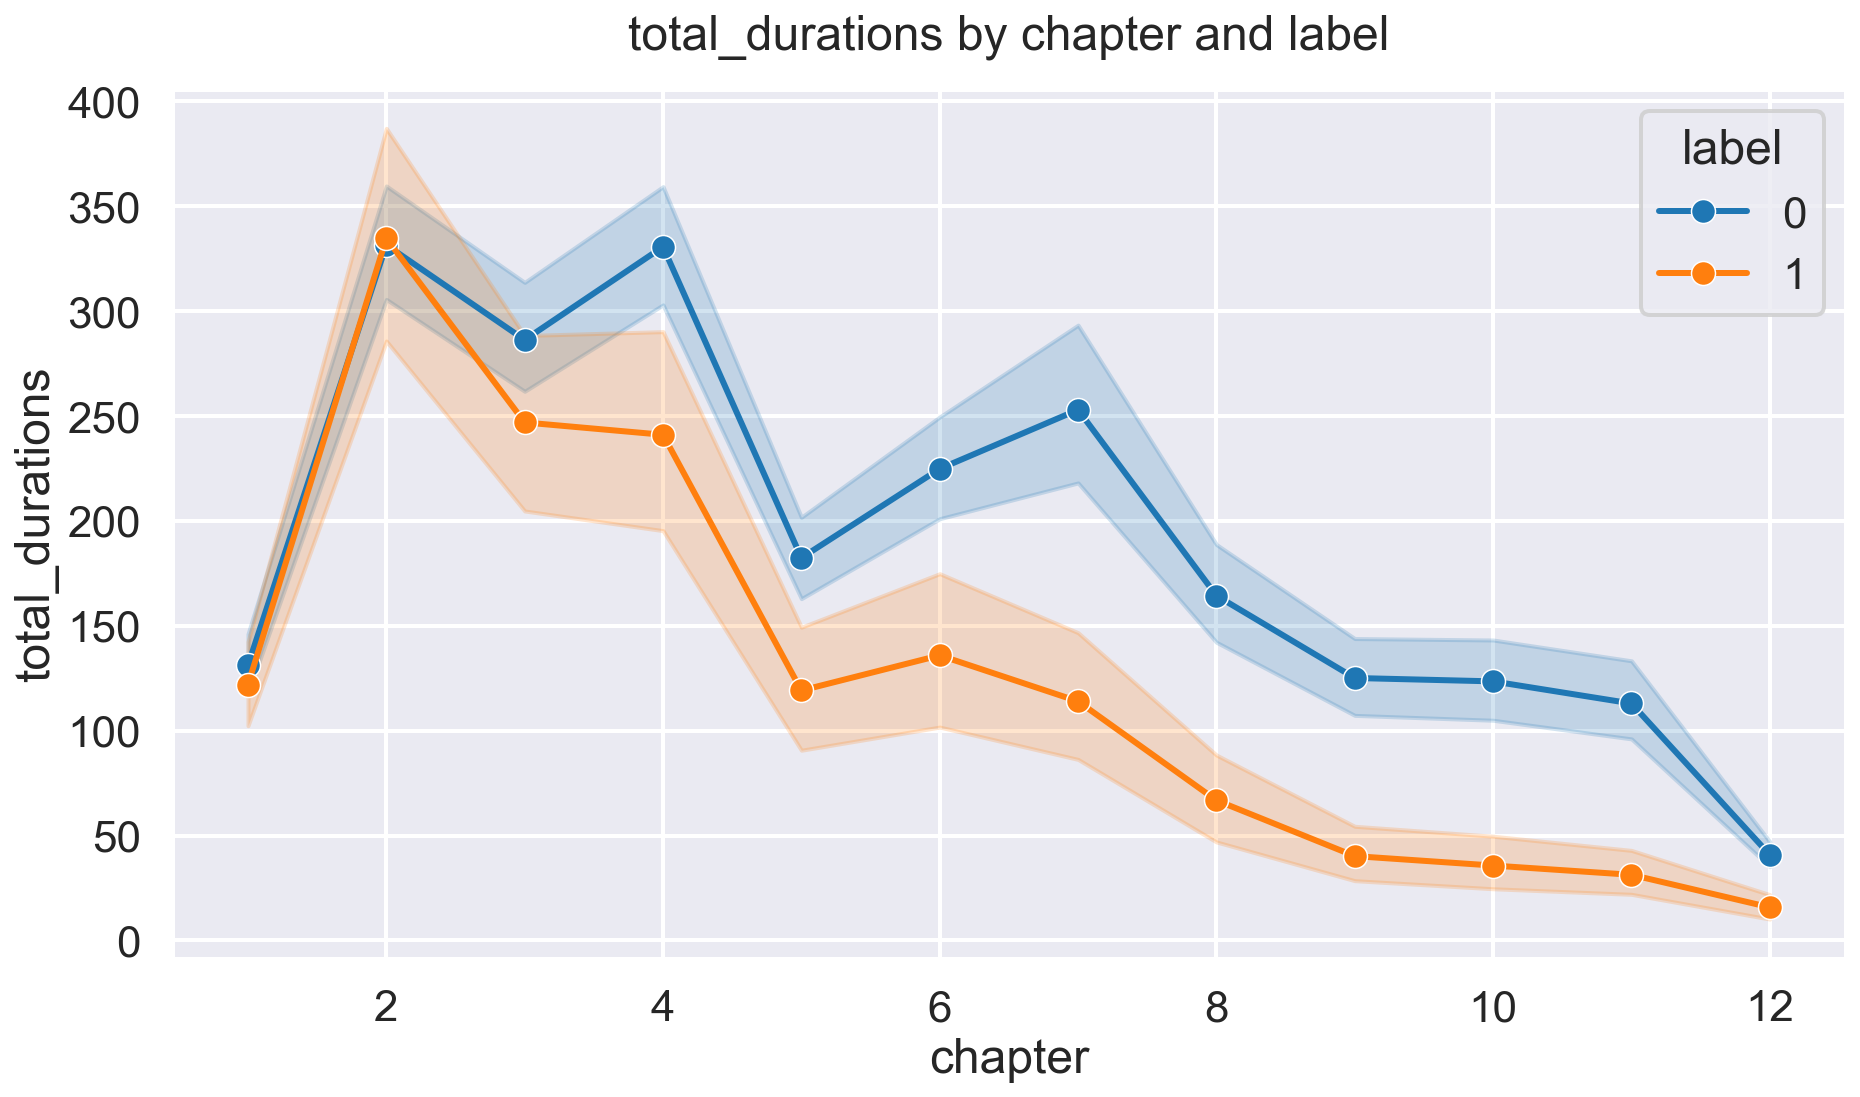

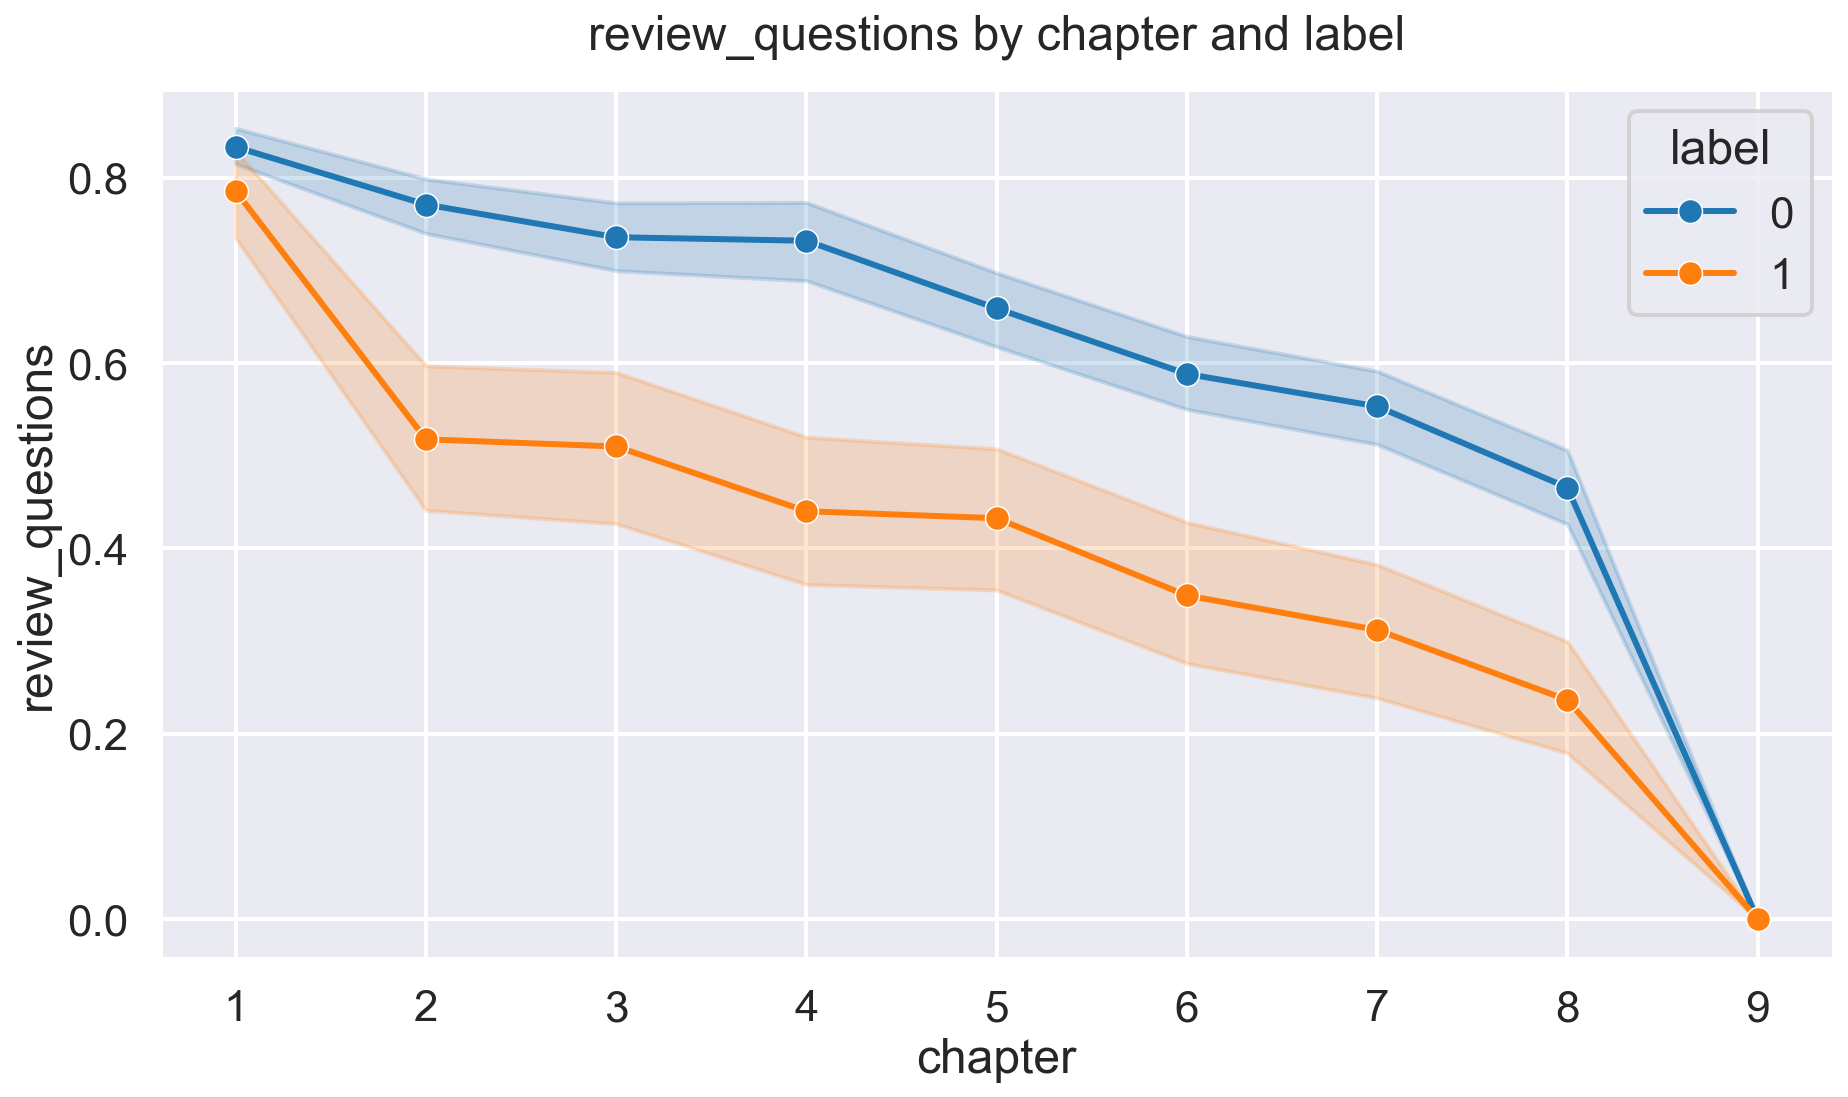

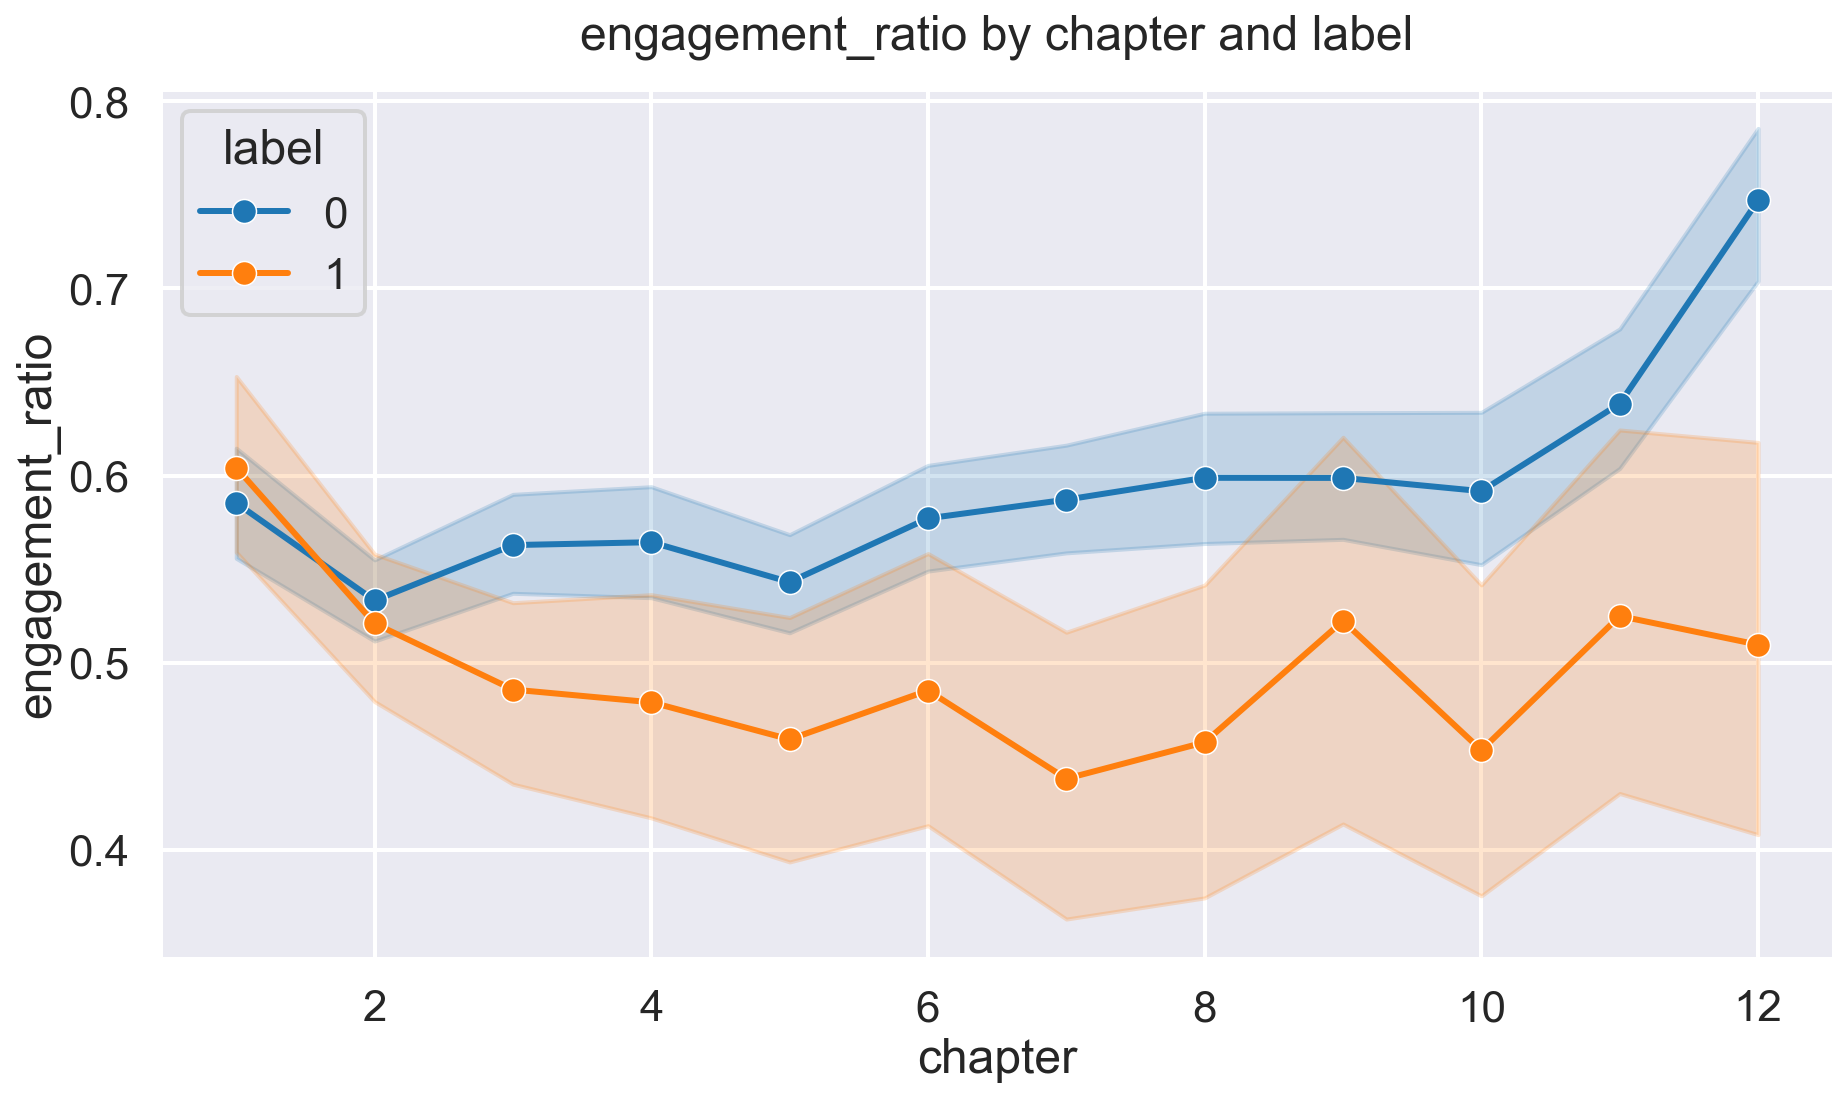

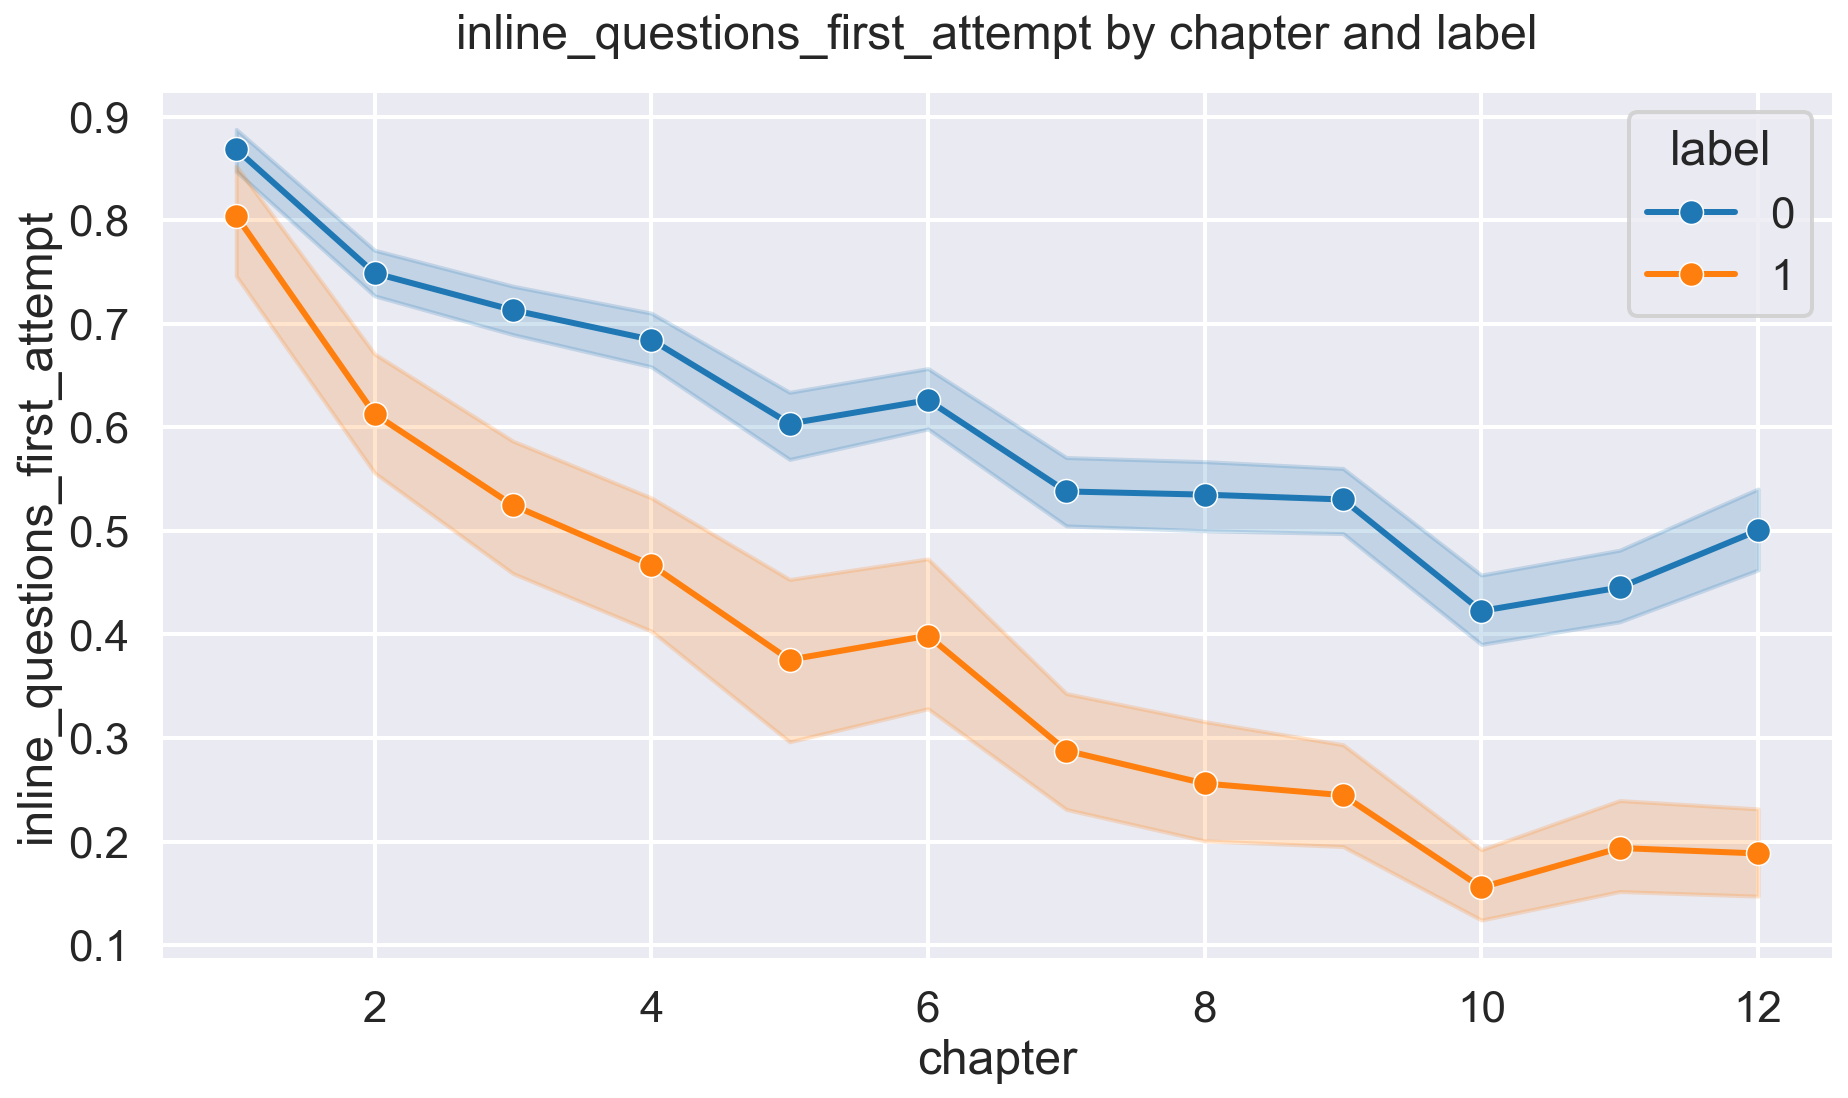

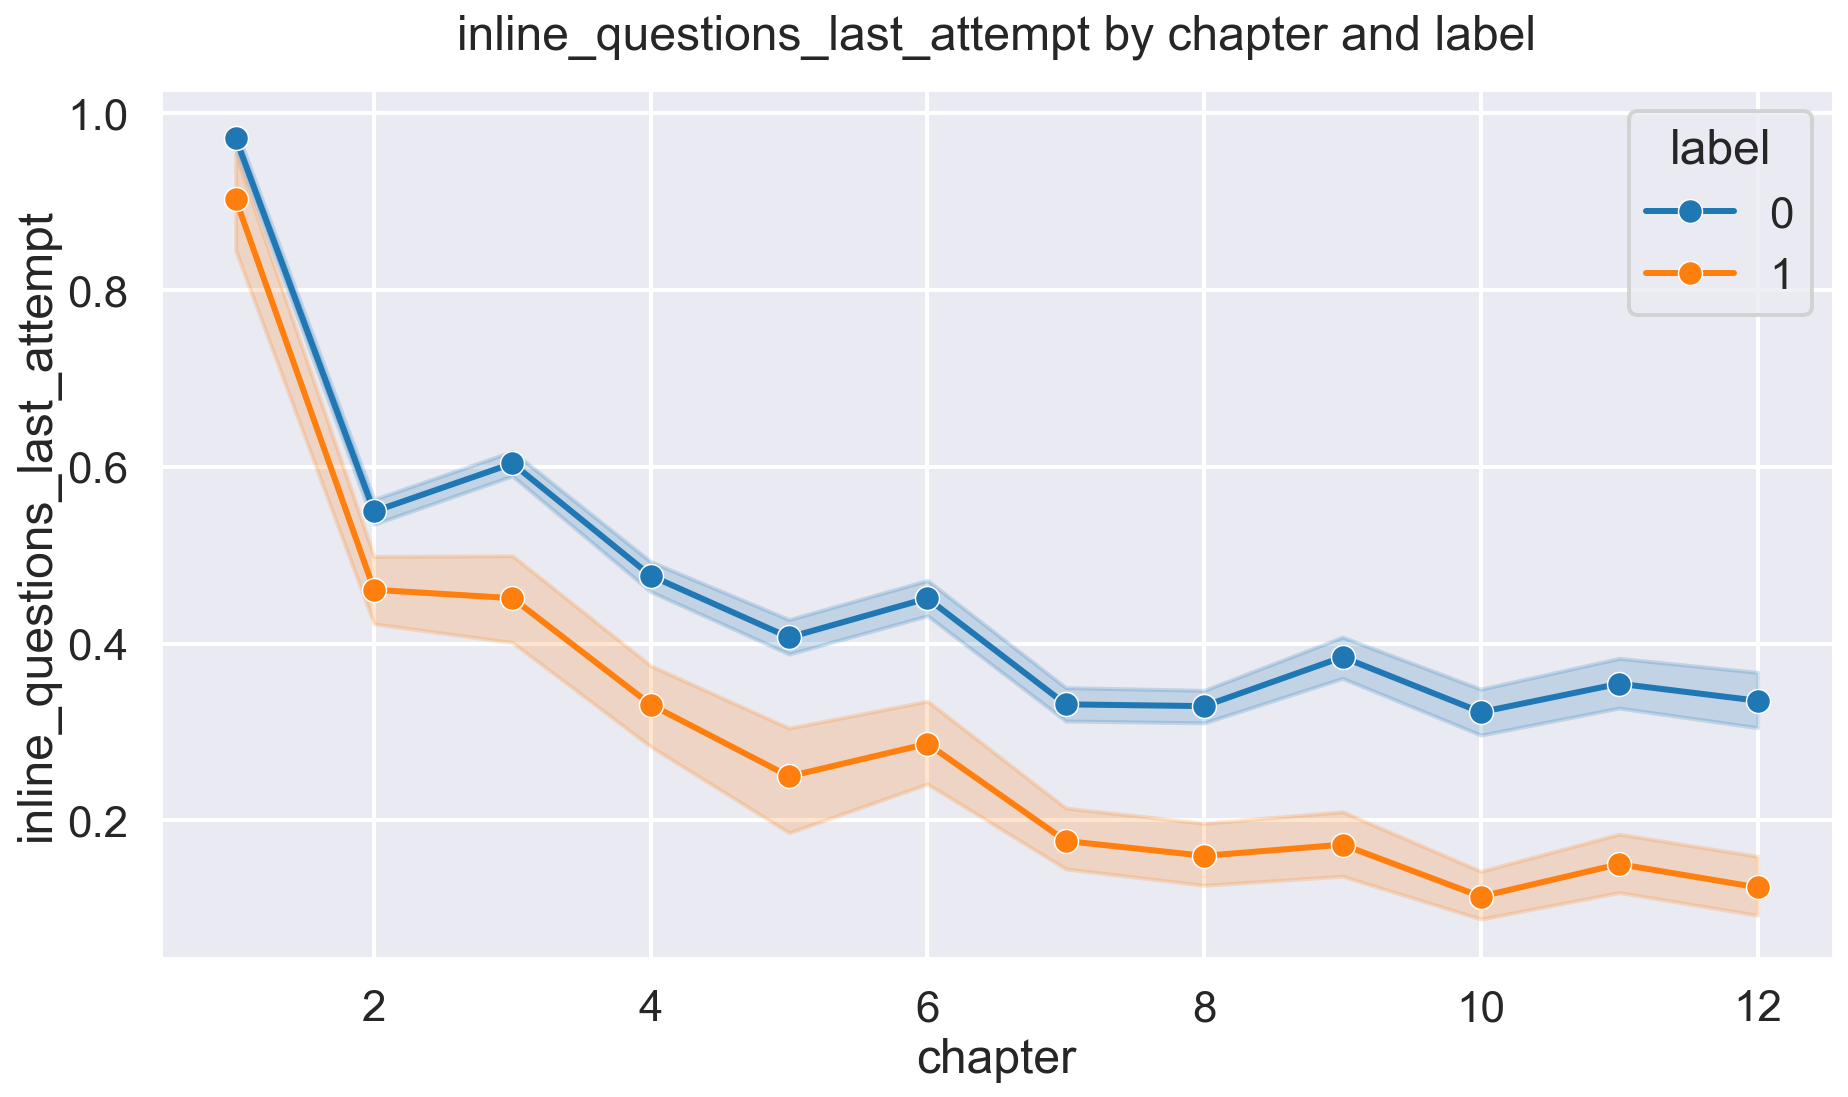

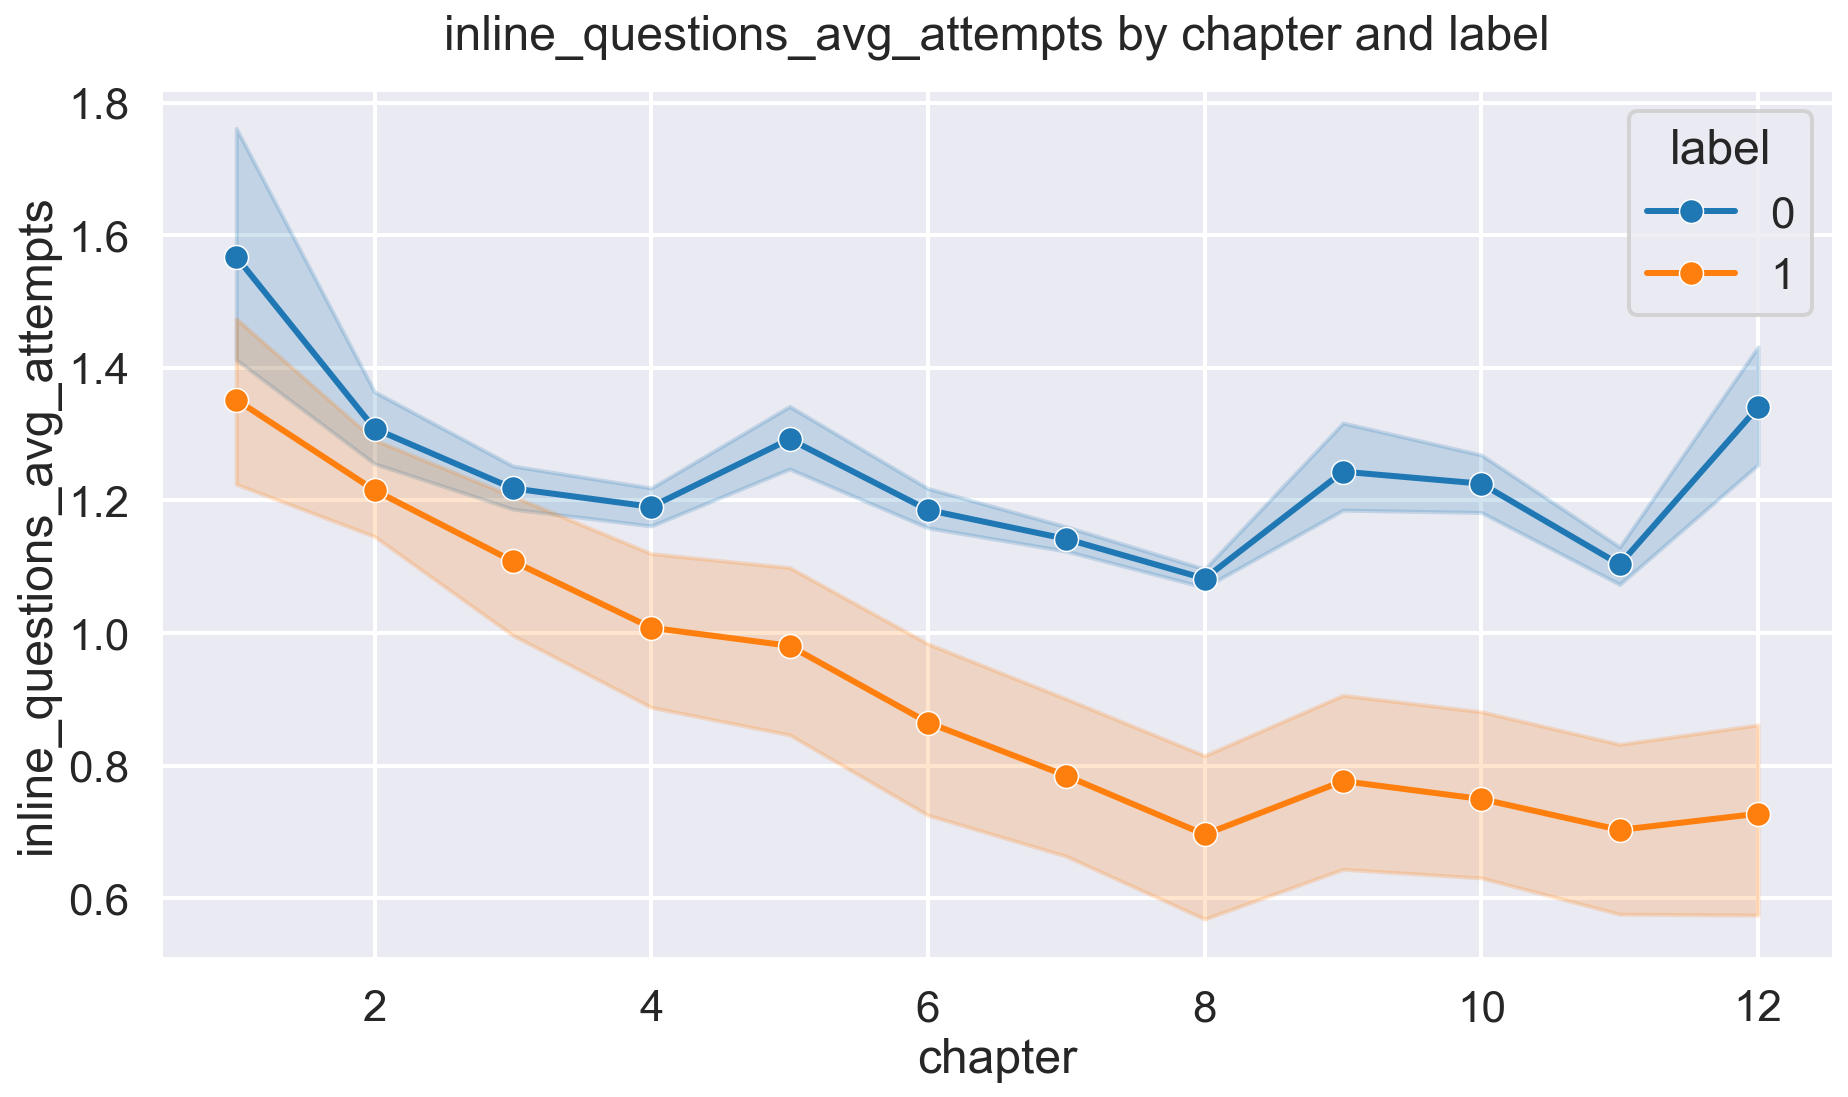

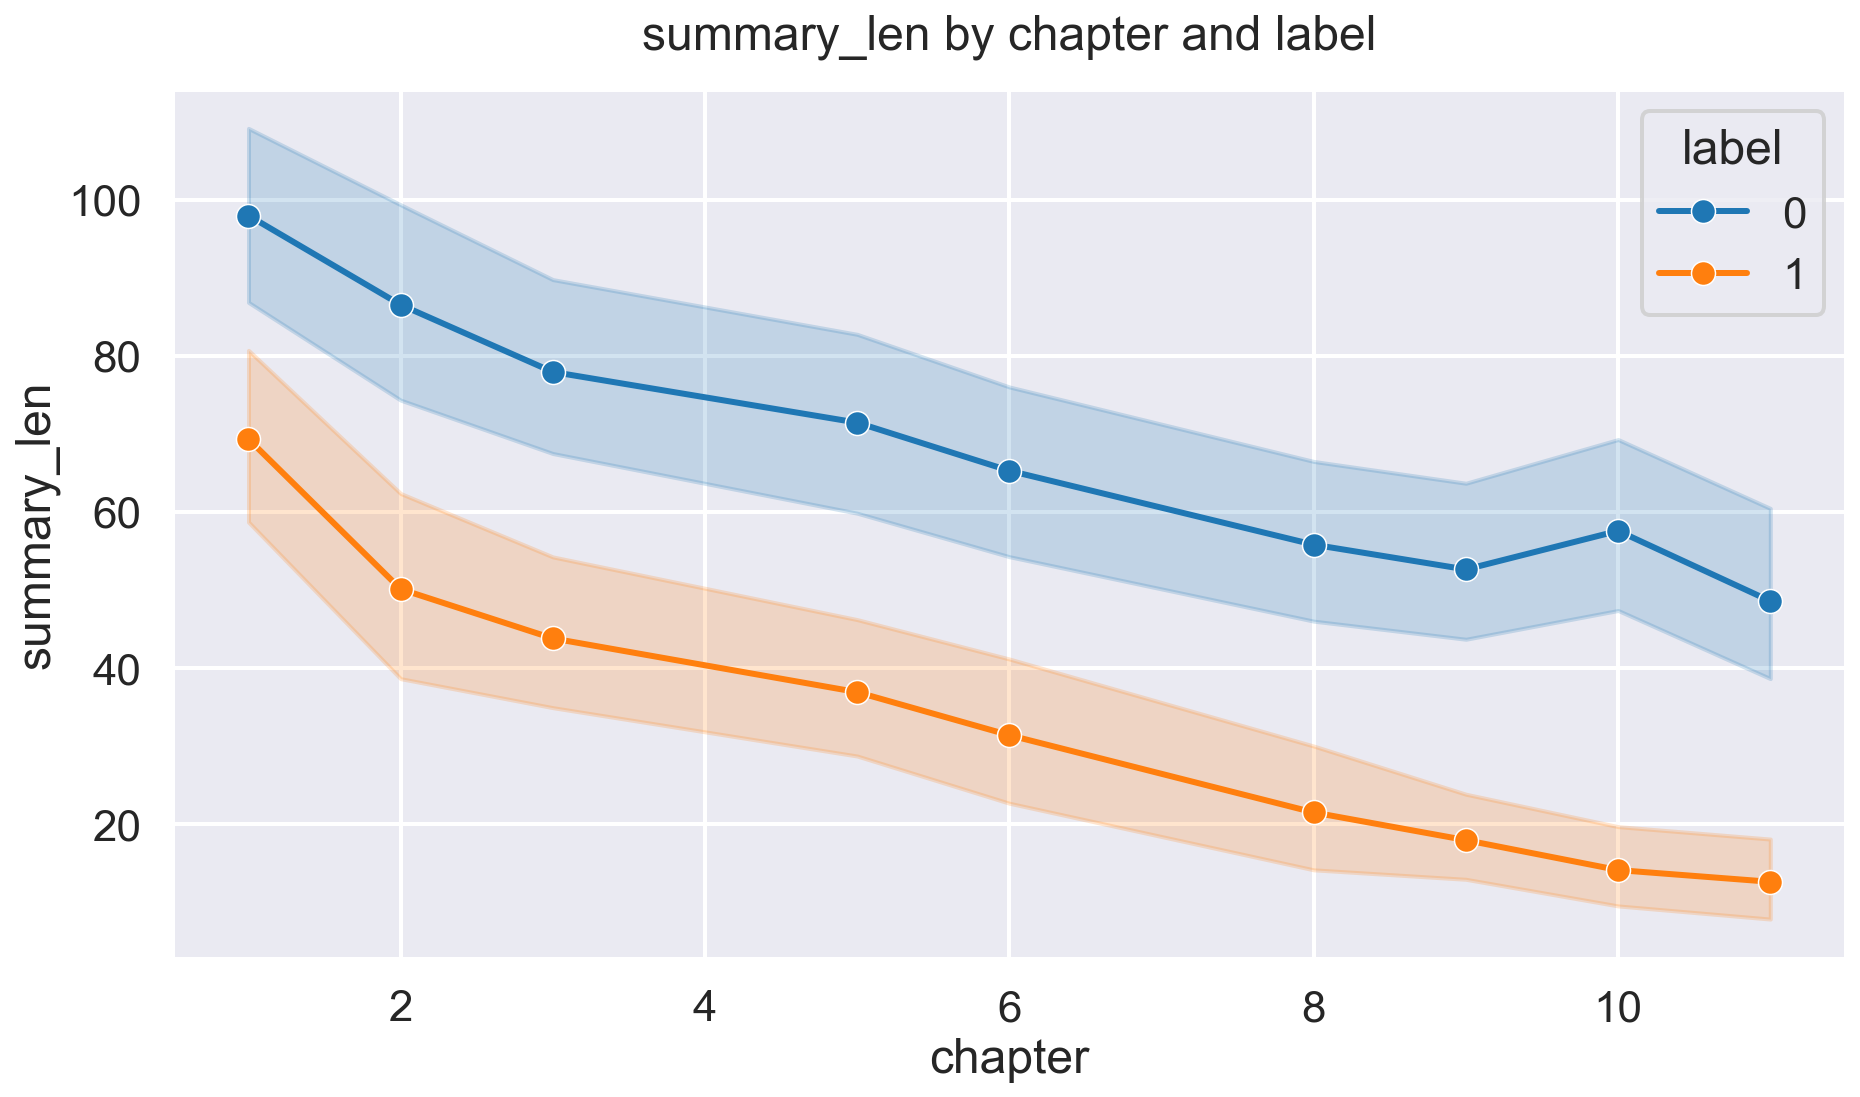

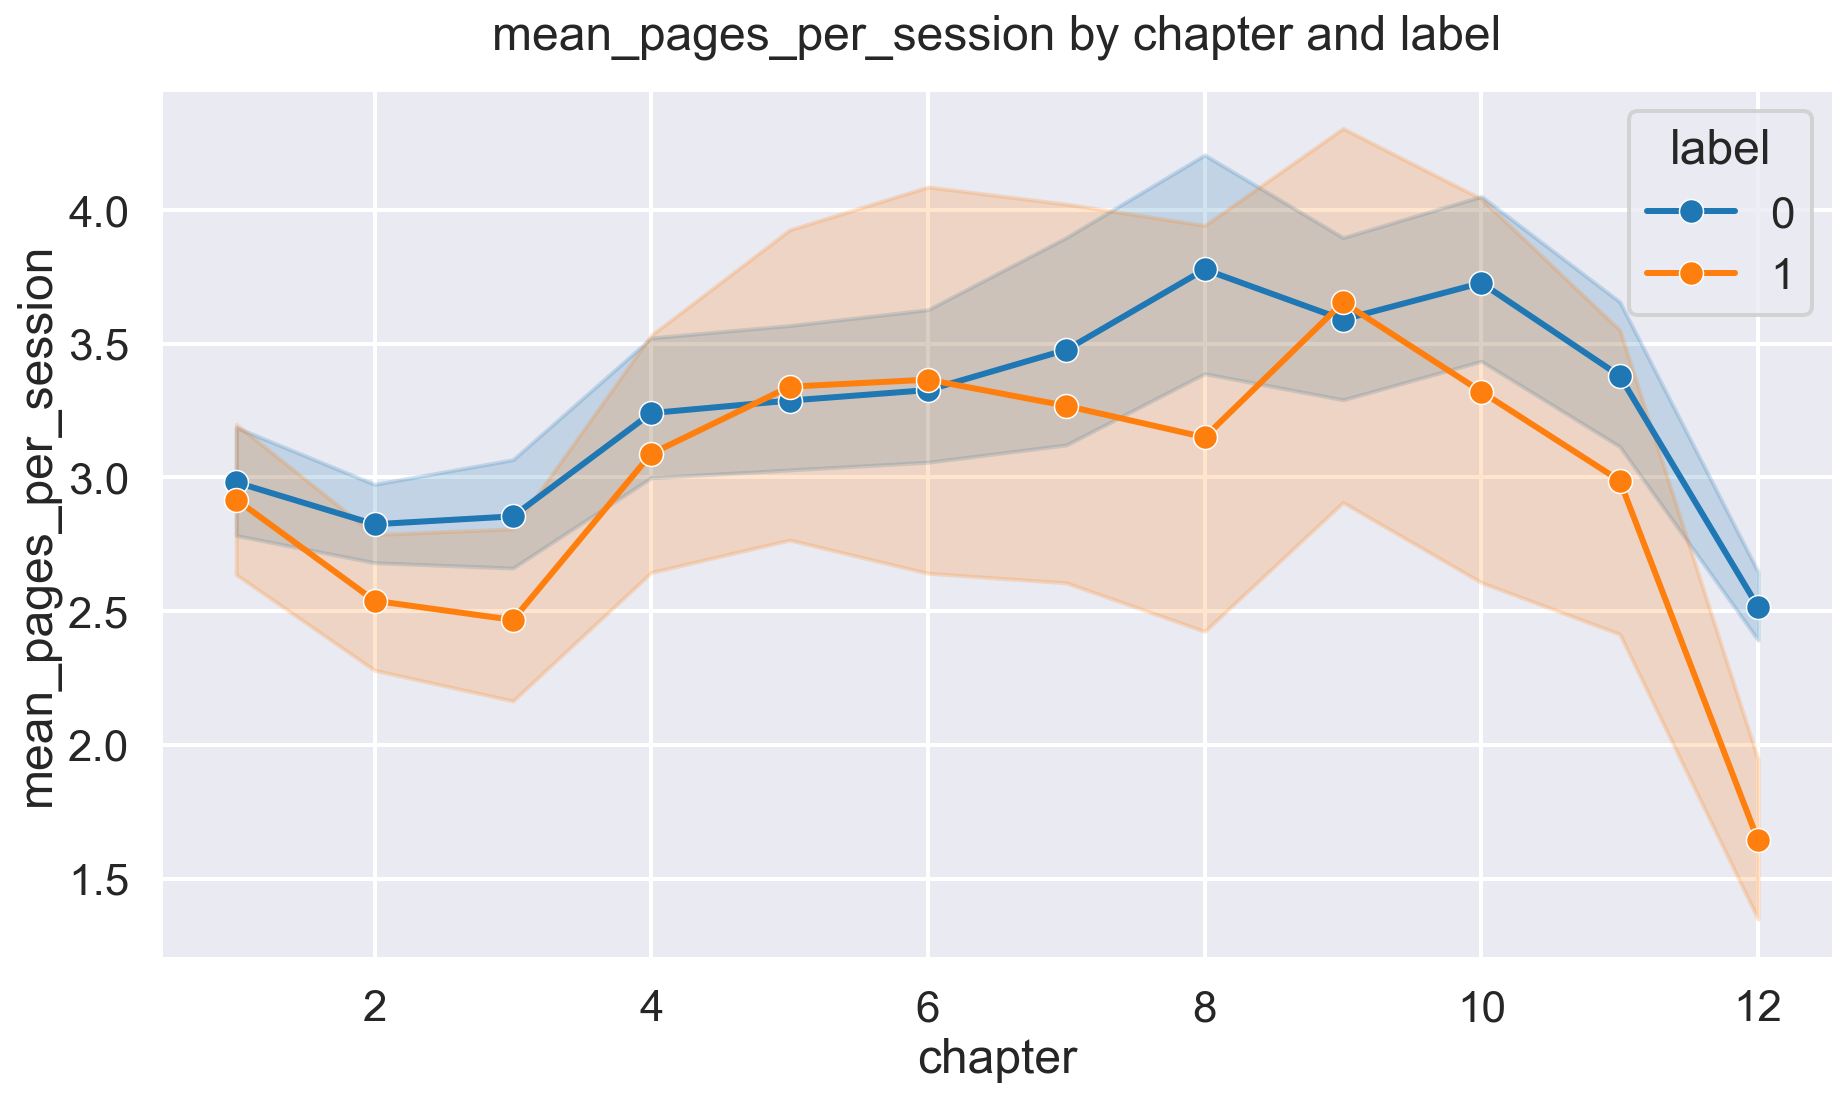

In [16]:
for feature in FEATURE_NAME_BY_FEATURE.keys():
    plot_feature_by_cluster(ucsd_data, feature, hue="label")